# A requested look at if healthcare visits vary between scenarios

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 8)

#import xarray as xr
import warnings
warnings.filterwarnings('ignore')
from matplotlib.backends.backend_pdf import PdfPages

from db_queries import get_outputs as go
from db_queries import get_ids
from get_draws.api import get_draws

In [2]:
sim_results_dir = '/mnt/team/simulation_science/pub/models/vivarium_nih_us_cvd/results/draw-testing/alabama/2023_10_27_16_00_55/count_data'

In [3]:
visits = pd.read_csv(sim_results_dir + '/healthcare_visits.csv')
visits = visits.loc[visits.year > 2022]
visits.head()

Unnamed: 0     sex  year            measure  input_draw       scenario  \
52500       52500  Female  2023  healthcare_visits           3       baseline   
52501       52501  Female  2023  healthcare_visits           3  lifestyle_100   
52502       52502  Female  2023  healthcare_visits           3   lifestyle_50   
52503       52503  Female  2023  healthcare_visits           3   outreach_100   
52504       52504  Female  2023  healthcare_visits           3    outreach_50   

            age  visit_type    value  
52500  25_to_29  background  22127.0  
52501  25_to_29  background  22127.0  
52502  25_to_29  background  22127.0  
52503  25_to_29  background  22127.0  
52504  25_to_29  background  22127.0

In [4]:
state_person_time = pd.read_csv(sim_results_dir + '/state_person_time.csv')
state_person_time = state_person_time.loc[state_person_time.year > 2022]
person_time = state_person_time.loc[state_person_time['state'].isin(["acute_ischemic_stroke", "chronic_ischemic_stroke", "susceptible_to_ischemic_stroke"])].reset_index() 
person_time = person_time.rename(columns = {'value':'ptvalue'})
per_time_group = person_time.groupby(['age', 'sex', 'year','input_draw','scenario']).ptvalue.sum().reset_index()
per_time_group.head()

age     sex  year  input_draw       scenario       ptvalue
0  25_to_29  Female  2023           3       baseline  10647.895962
1  25_to_29  Female  2023           3  lifestyle_100  10647.895962
2  25_to_29  Female  2023           3   lifestyle_50  10647.895962
3  25_to_29  Female  2023           3   outreach_100  10647.895962
4  25_to_29  Female  2023           3    outreach_50  10647.895962

In [5]:
screen = visits.loc[visits['visit_type']=='background'].reset_index()
screen_rate = screen.merge(per_time_group[['ptvalue','sex','age','year','input_draw','scenario']], on=['sex','age','year','input_draw','scenario'])
screen_rate['screen_rate'] = screen_rate['value'] / screen_rate['ptvalue']
screen_rate_summ = (screen_rate
                .groupby(['age', 'sex', 'year','scenario'])
                .screen_rate.describe(percentiles=[.025, .975])
                .filter(['mean', '2.5%', '97.5%'])
                .reset_index())
screen_rate_summ.head()

age     sex  year       scenario      mean      2.5%     97.5%
0  25_to_29  Female  2023       baseline  2.217604  1.506135  3.560467
1  25_to_29  Female  2023  lifestyle_100  2.217604  1.506135  3.560467
2  25_to_29  Female  2023   lifestyle_50  2.217604  1.506135  3.560467
3  25_to_29  Female  2023   outreach_100  2.217604  1.506135  3.560467
4  25_to_29  Female  2023    outreach_50  2.217604  1.506135  3.560467

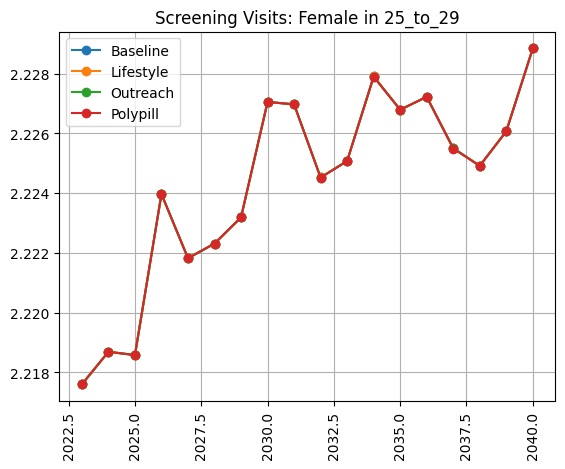

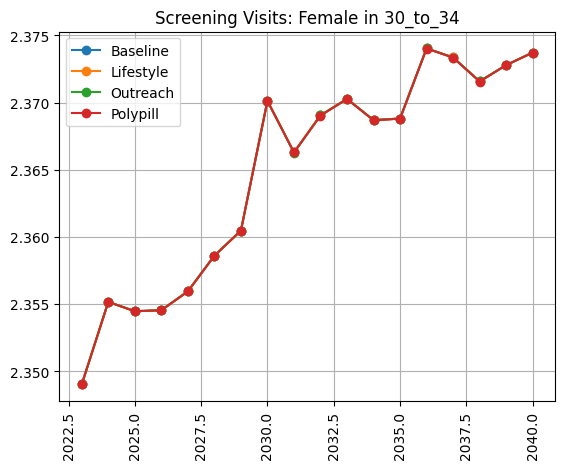

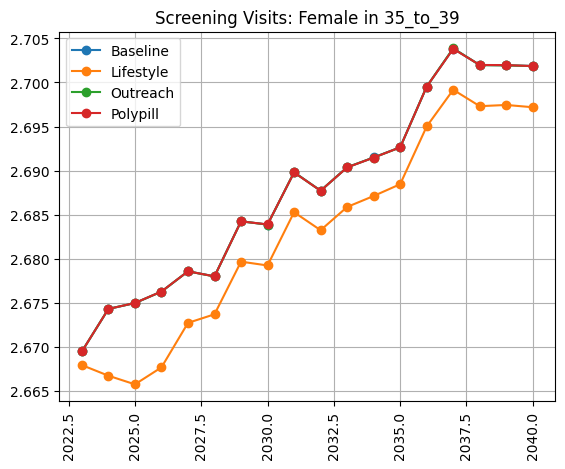

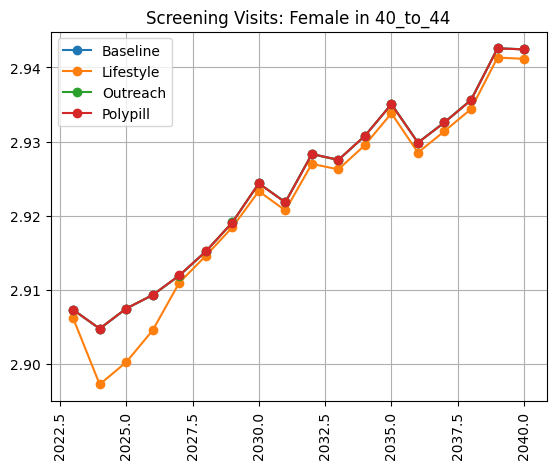

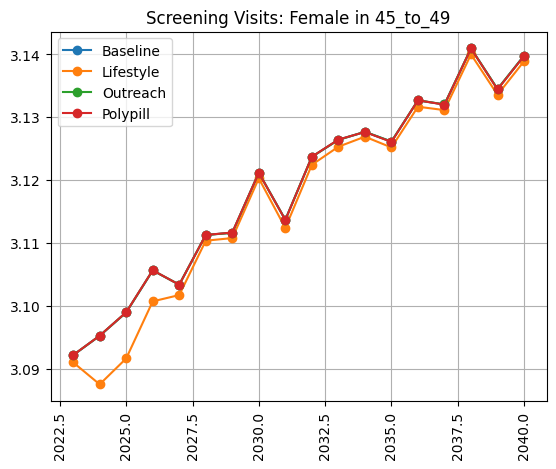

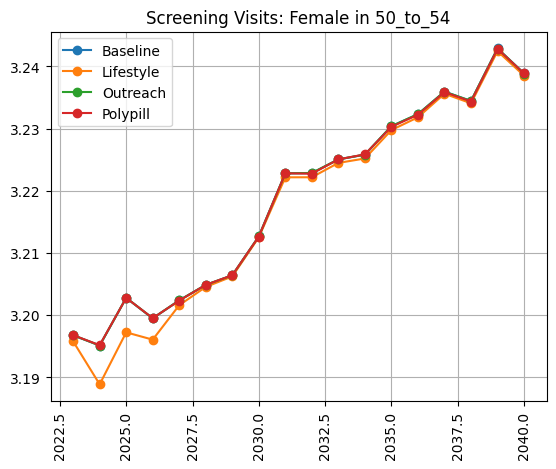

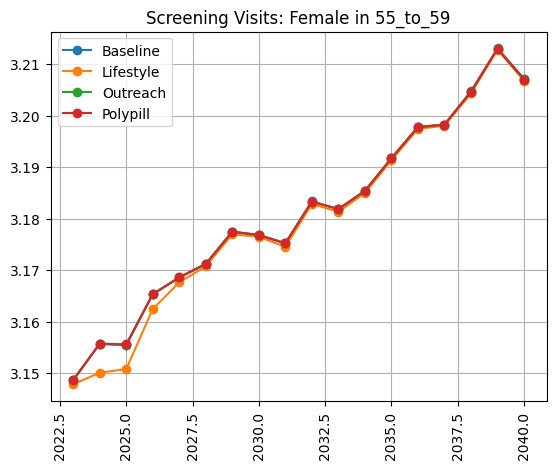

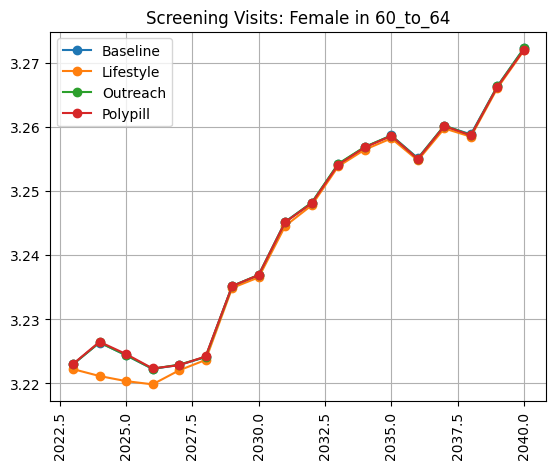

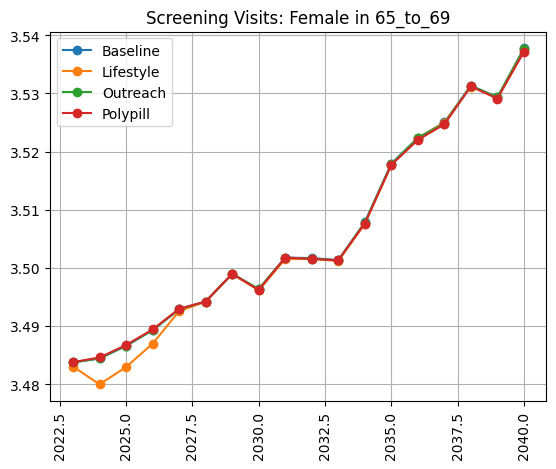

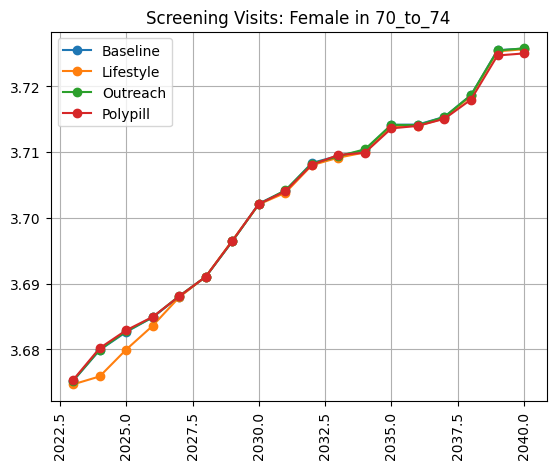

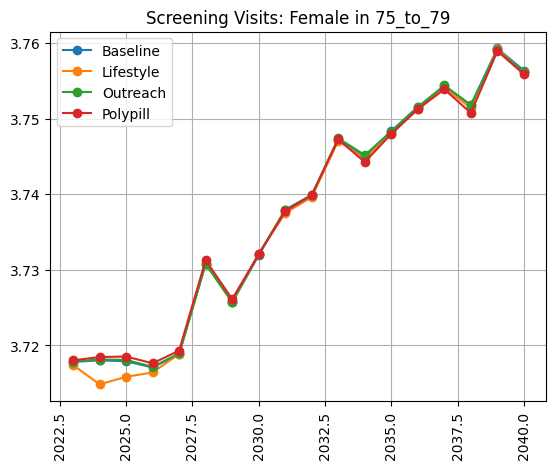

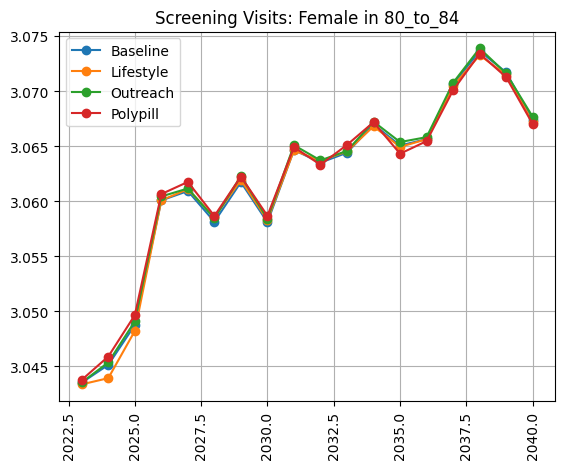

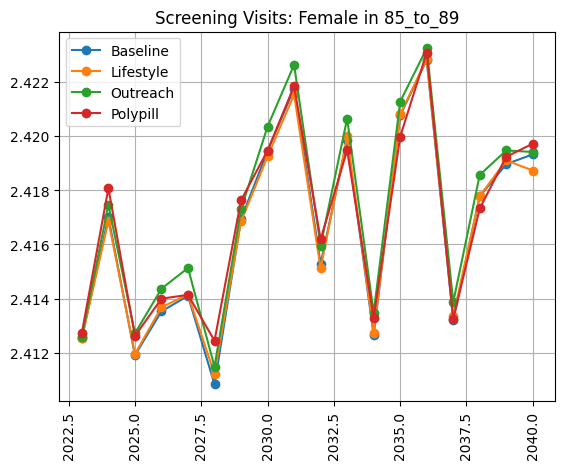

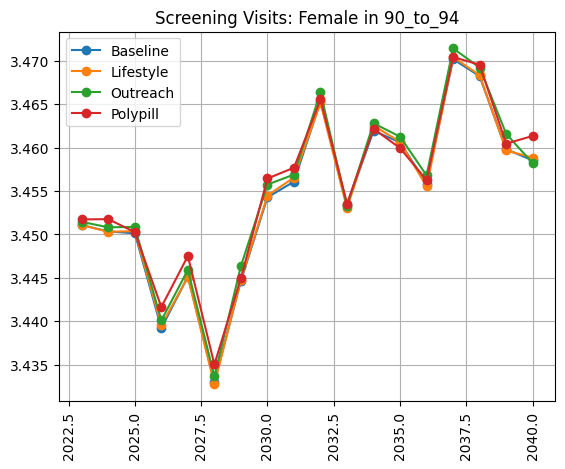

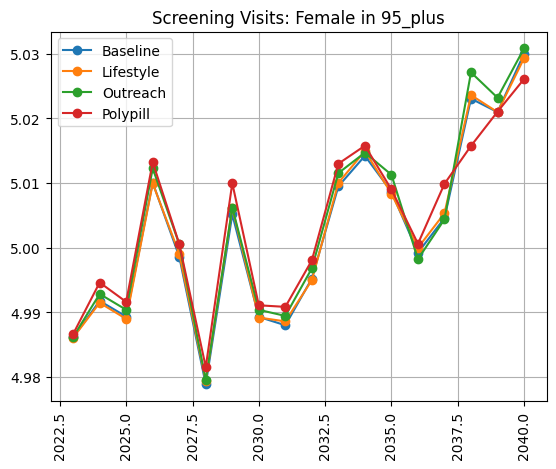

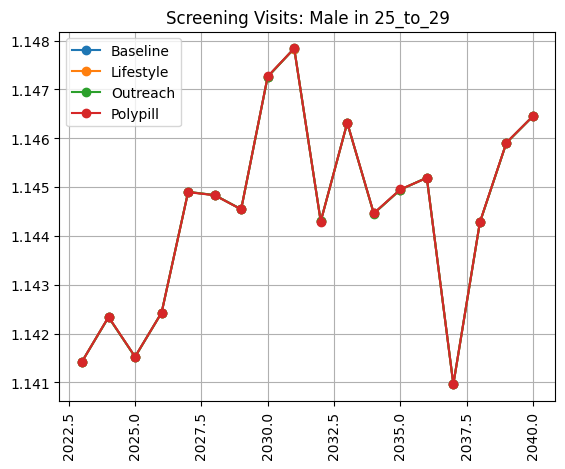

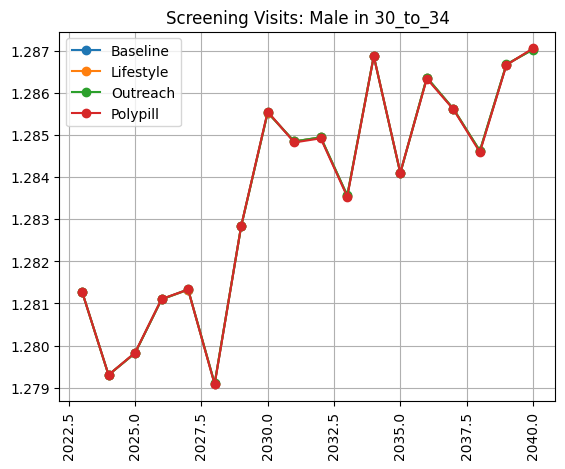

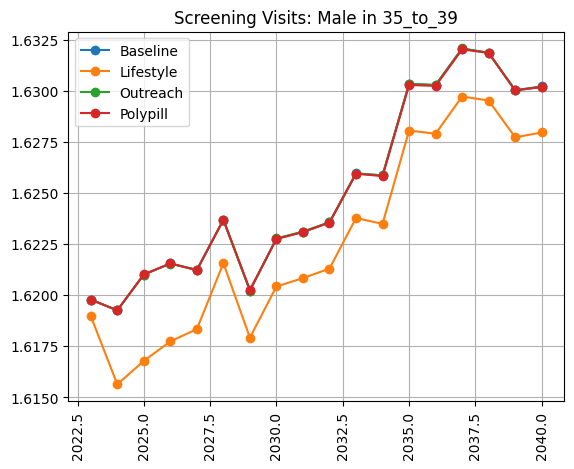

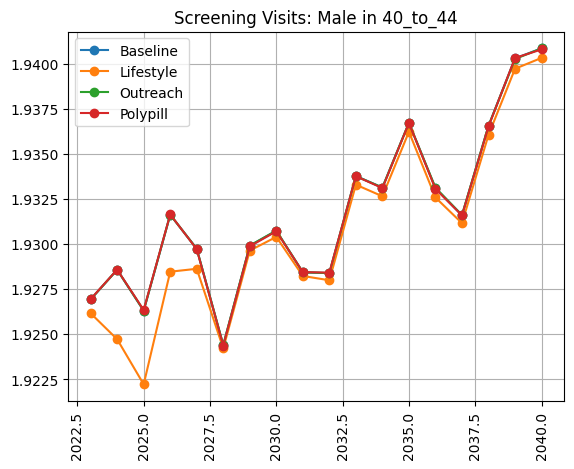

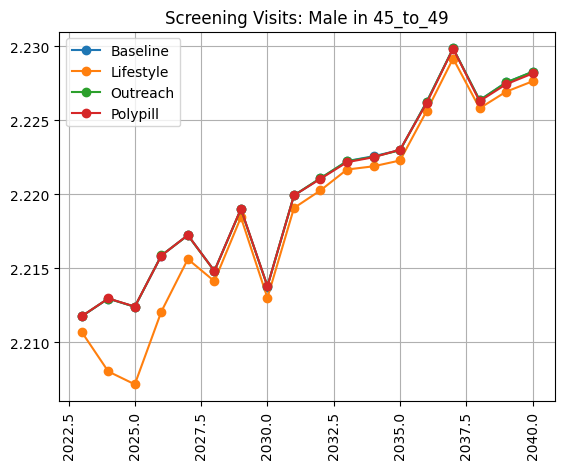

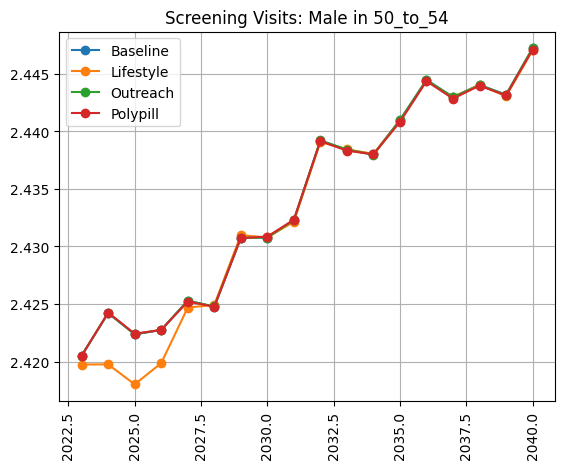

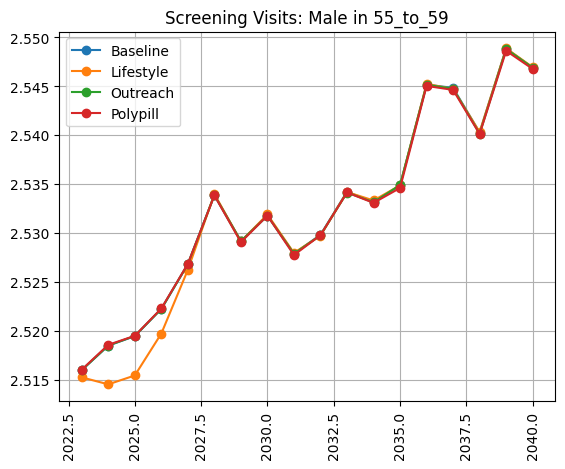

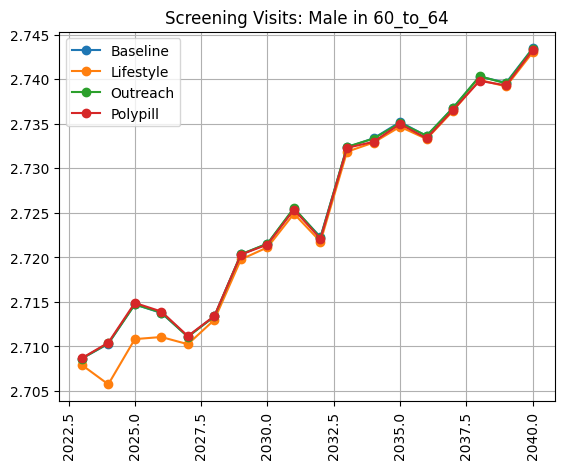

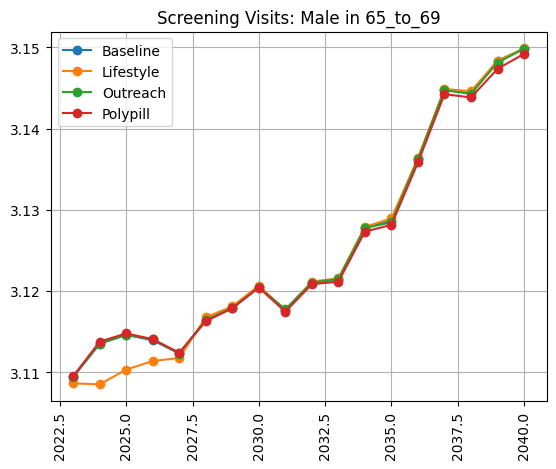

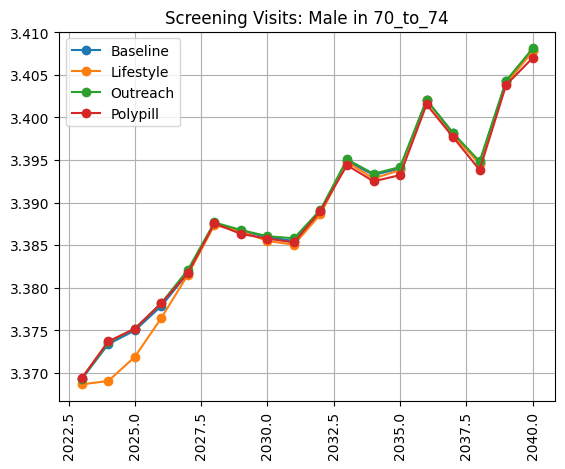

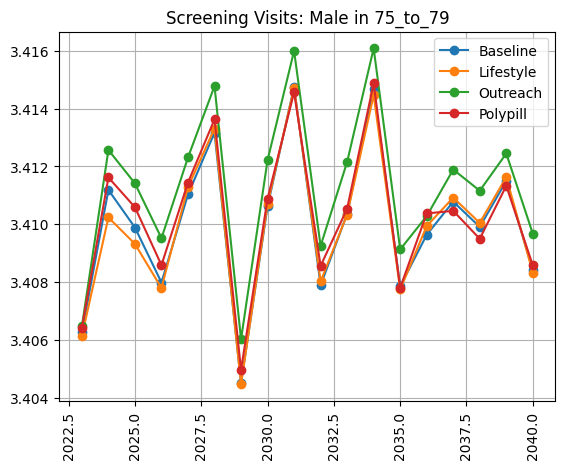

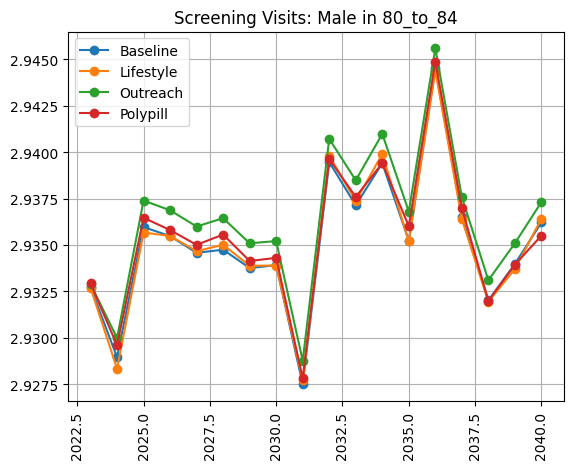

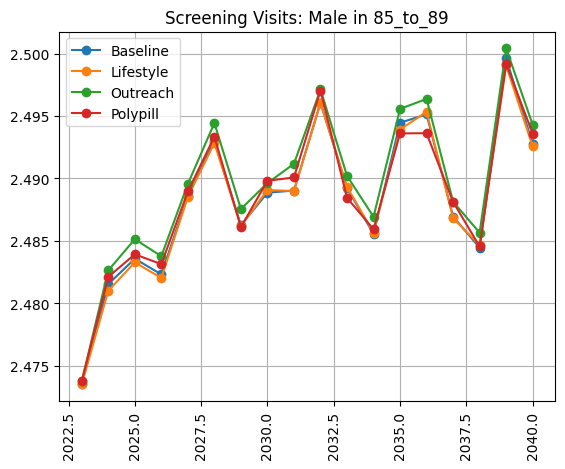

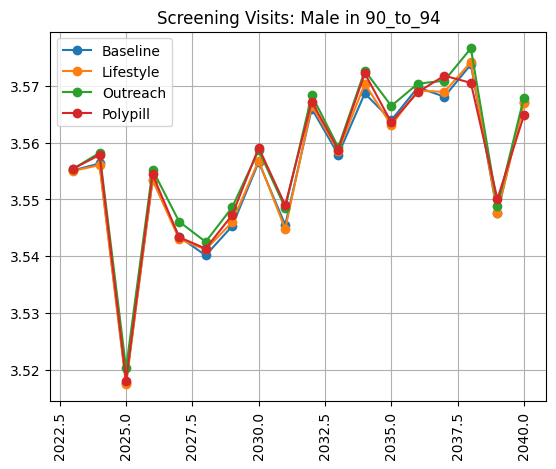

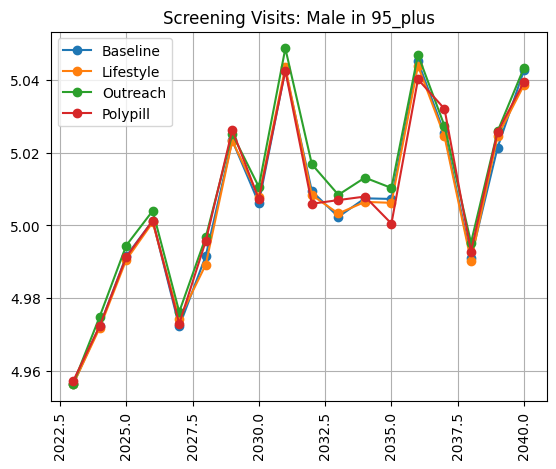

In [6]:
#%%capture
for sex in screen_rate_summ.sex.unique():
    for age in screen_rate_summ.age.unique():
        plt.figure() 
        subdata = screen_rate_summ.loc[(screen_rate_summ.sex==sex) & (screen_rate_summ.age==age)&(screen_rate_summ.scenario=='baseline')]
        plt.plot(subdata['year'], subdata['mean'], marker='o')
        subdata = screen_rate_summ.loc[(screen_rate_summ.sex==sex) & (screen_rate_summ.age==age)&(screen_rate_summ.scenario=='lifestyle_100')]
        plt.plot(subdata['year'], subdata['mean'], marker='o')
        subdata = screen_rate_summ.loc[(screen_rate_summ.sex==sex) & (screen_rate_summ.age==age)&(screen_rate_summ.scenario=='outreach_100')]
        plt.plot(subdata['year'], subdata['mean'], marker='o')
        subdata = screen_rate_summ.loc[(screen_rate_summ.sex==sex) & (screen_rate_summ.age==age)&(screen_rate_summ.scenario=='polypill_100')]
        plt.plot(subdata['year'], subdata['mean'], marker='o')
        plt.legend(['Baseline','Lifestyle','Outreach','Polypill'])
        plt.title(f'Screening Visits: {sex} in {age}') 
        plt.xticks(rotation=90) 
        plt.grid()

In [7]:
followup = visits.loc[visits['visit_type']=='scheduled'].reset_index()
followup_rate = followup.merge(per_time_group[['ptvalue','sex','age','year','input_draw','scenario']], on=['sex','age','year','input_draw','scenario'])
followup_rate['followup_rate'] = followup_rate['value'] / followup_rate['ptvalue']
followup_rate_summ = (followup_rate
                .groupby(['age', 'sex', 'year','scenario'])
                .followup_rate.describe(percentiles=[.025, .975])
                .filter(['mean', '2.5%', '97.5%'])
                .reset_index())
followup_rate_summ.head()

age     sex  year       scenario      mean      2.5%     97.5%
0  25_to_29  Female  2023       baseline  0.225596  0.190255  0.276608
1  25_to_29  Female  2023  lifestyle_100  0.225596  0.190255  0.276608
2  25_to_29  Female  2023   lifestyle_50  0.225596  0.190255  0.276608
3  25_to_29  Female  2023   outreach_100  0.225596  0.190255  0.276608
4  25_to_29  Female  2023    outreach_50  0.225596  0.190255  0.276608

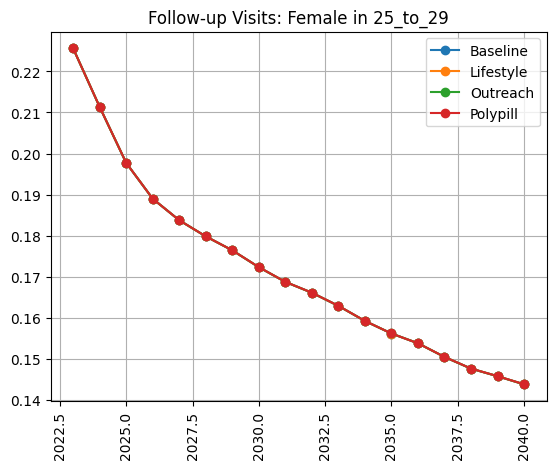

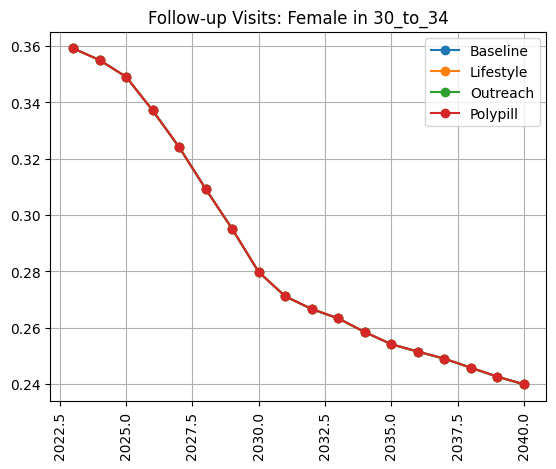

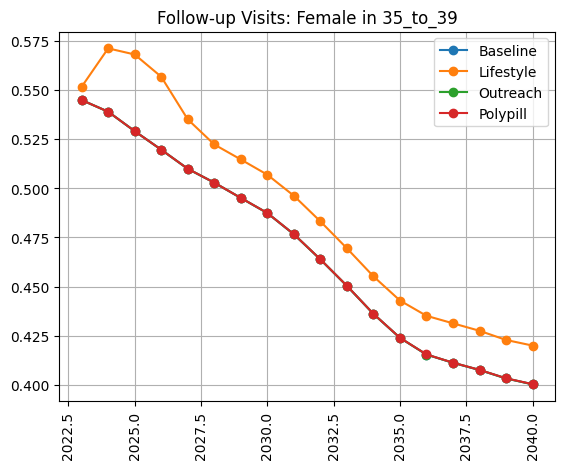

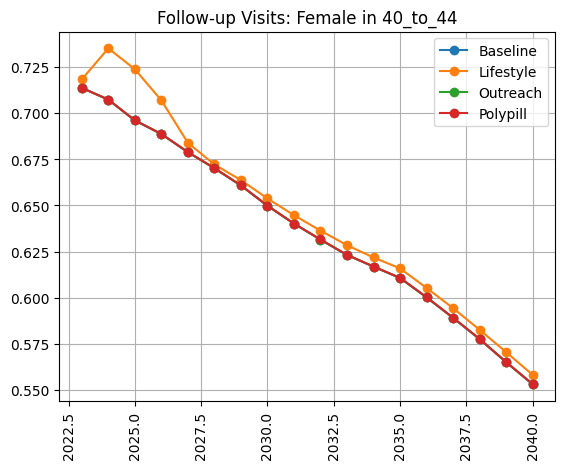

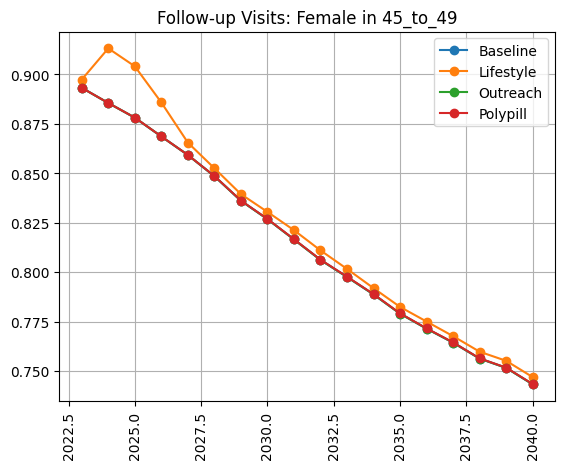

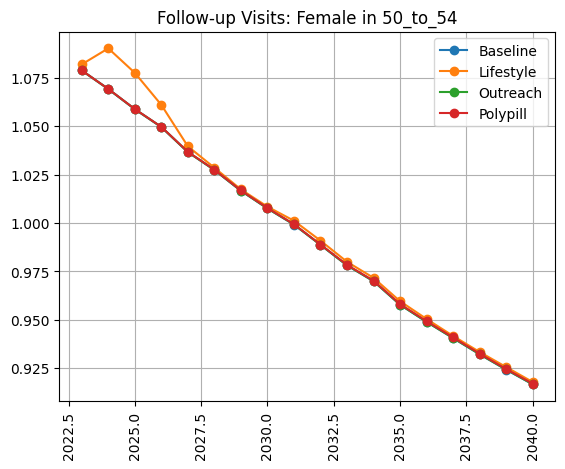

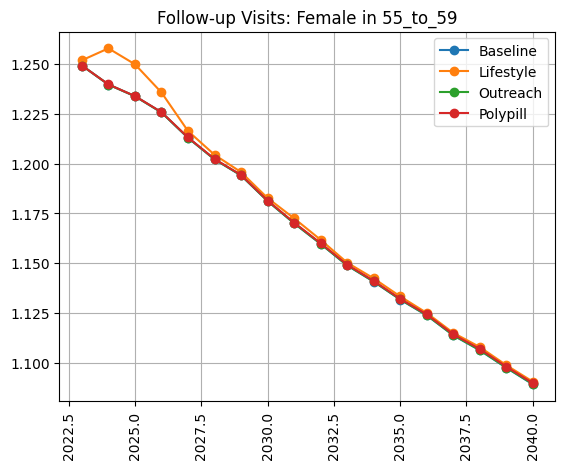

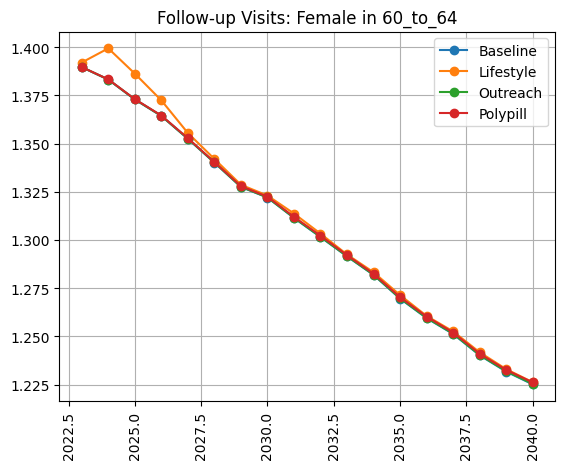

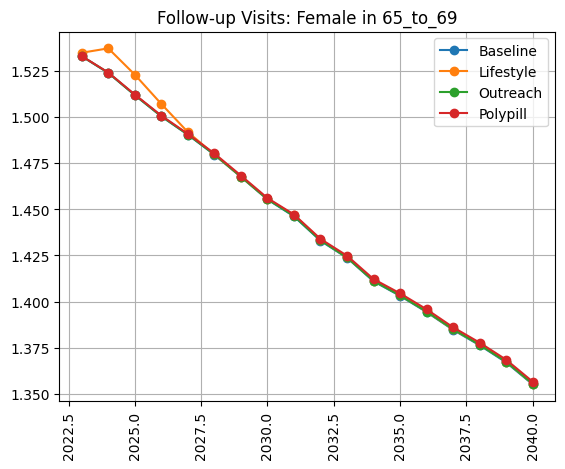

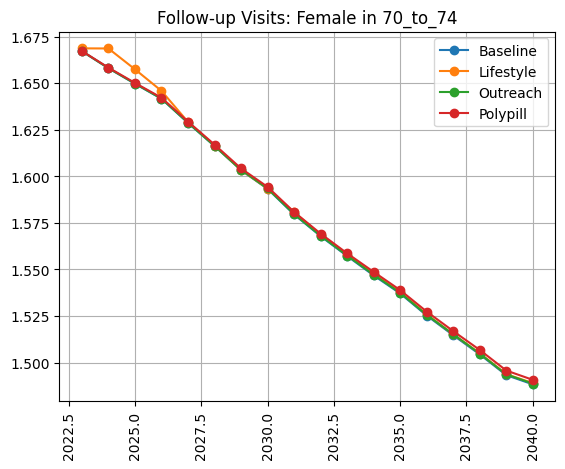

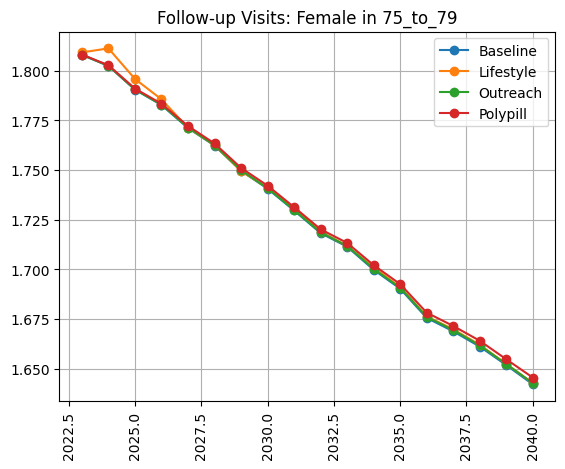

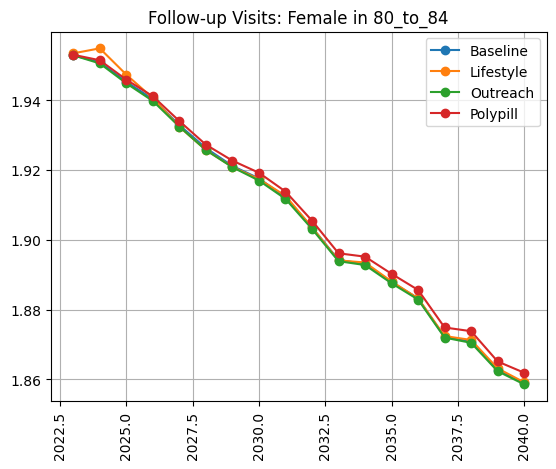

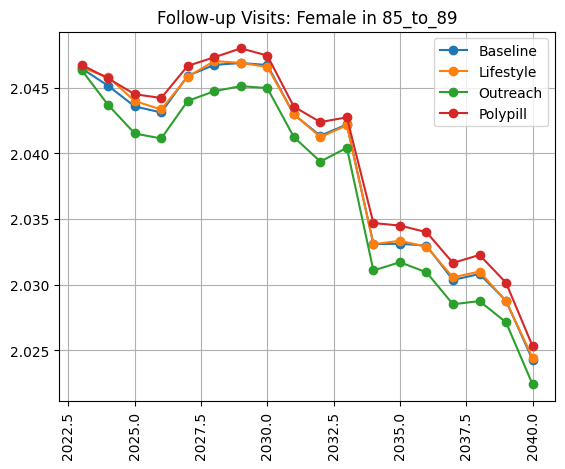

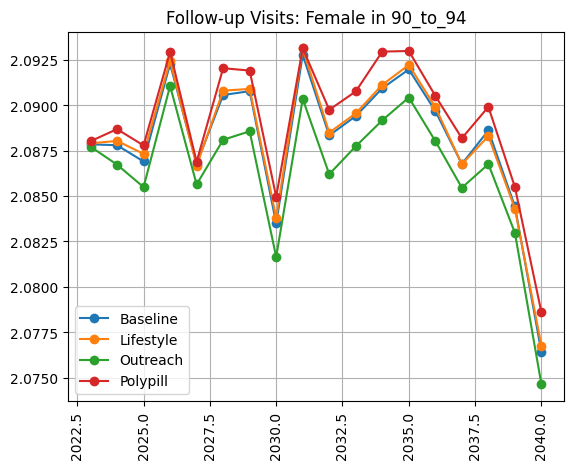

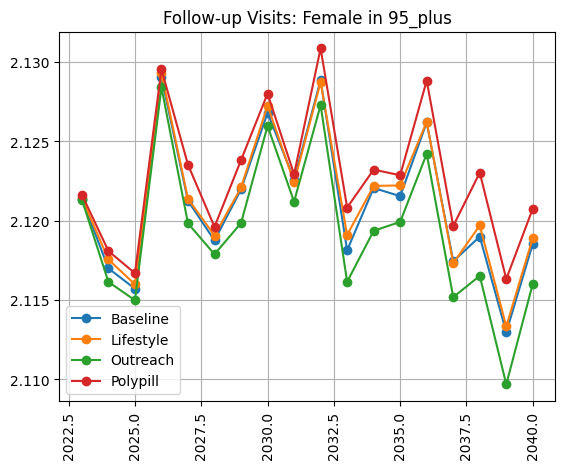

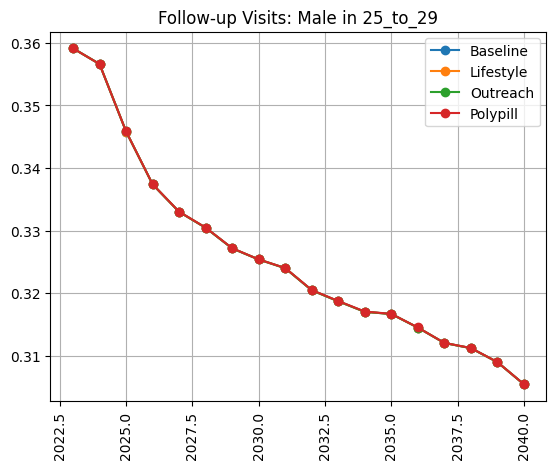

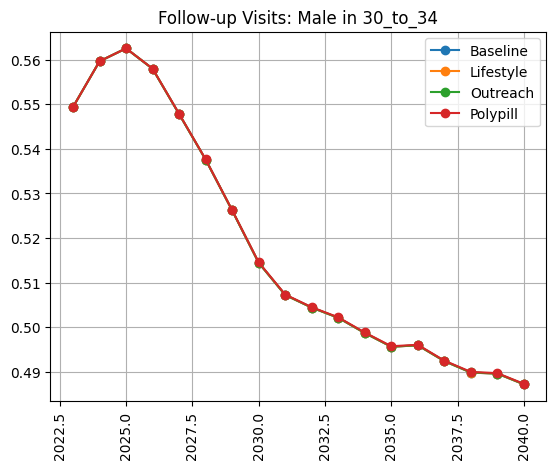

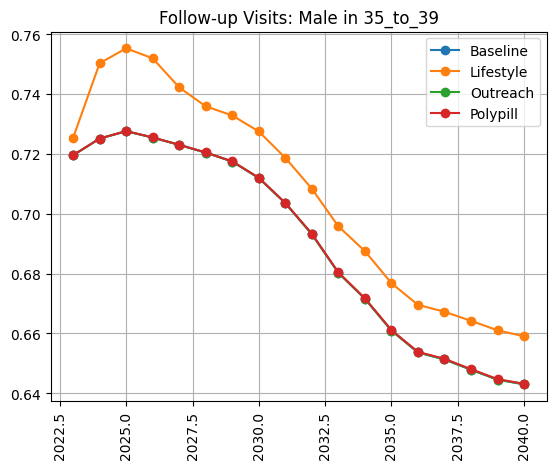

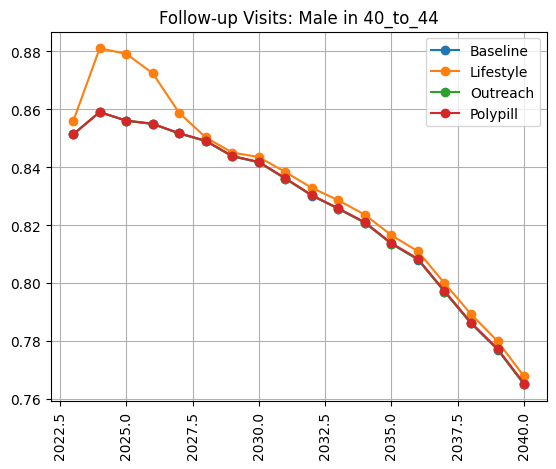

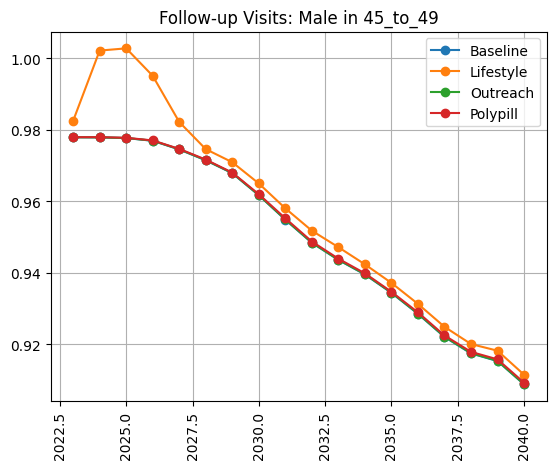

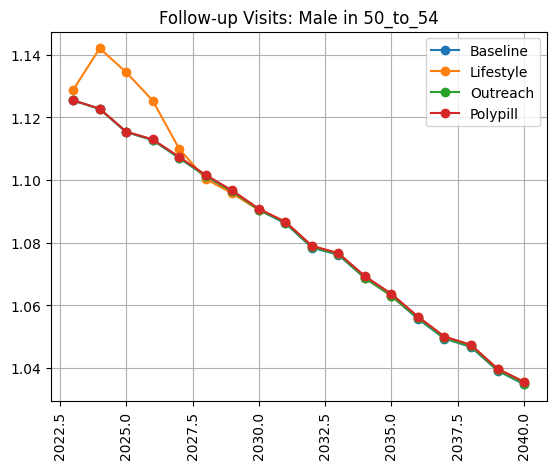

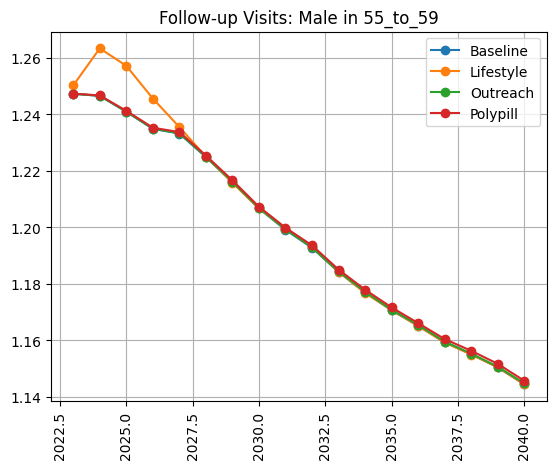

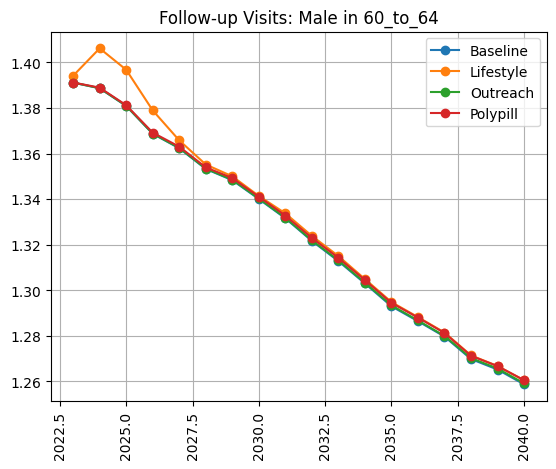

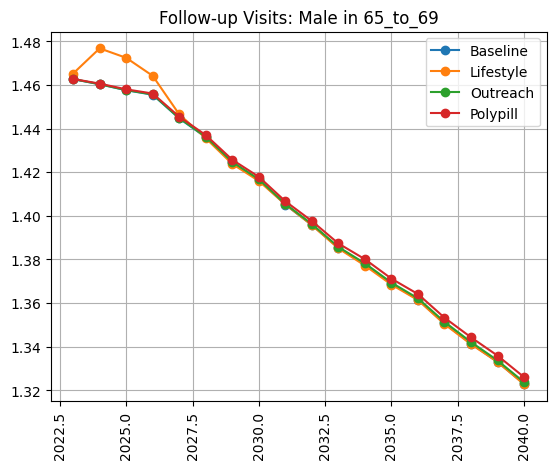

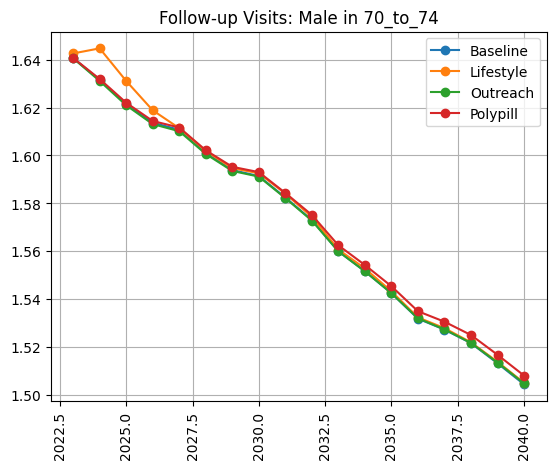

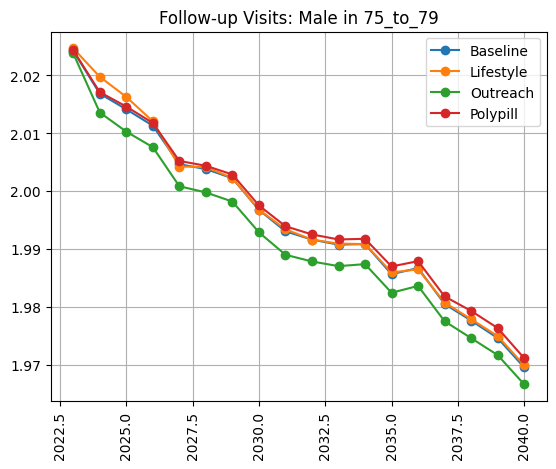

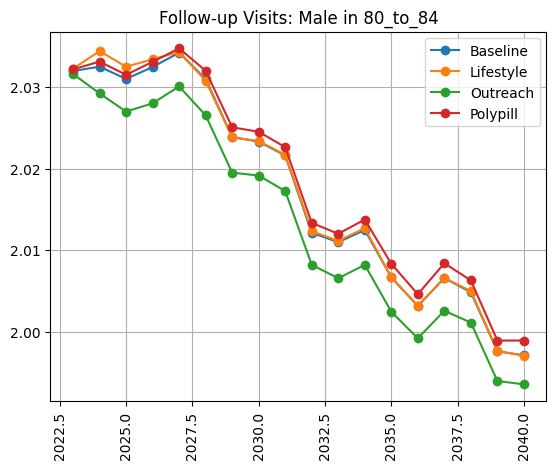

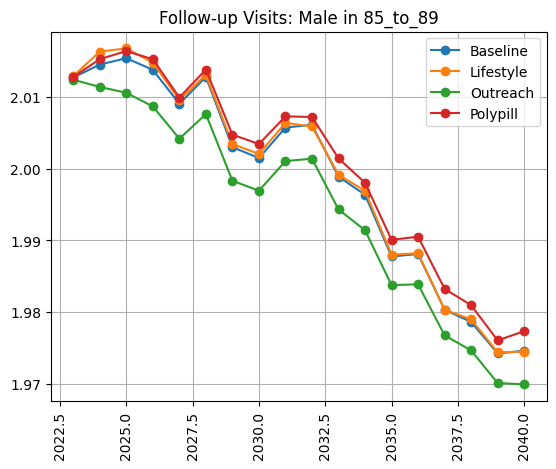

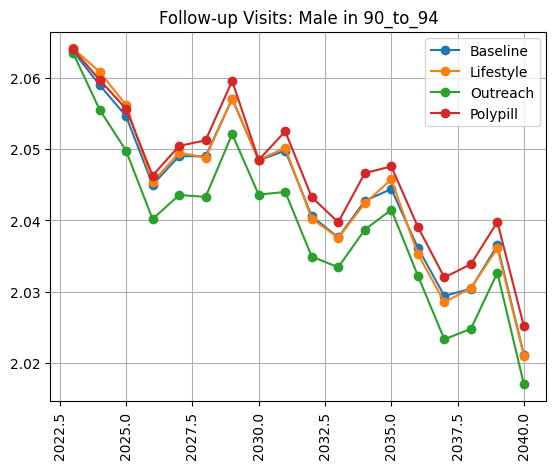

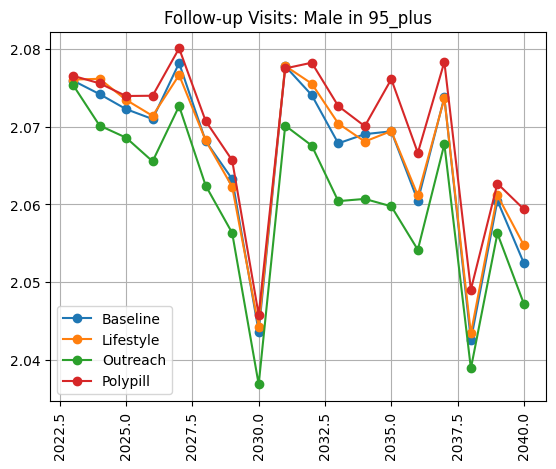

In [8]:
#%%capture
for sex in followup_rate_summ.sex.unique():
    for age in followup_rate_summ.age.unique():
        plt.figure() 
        subdata = followup_rate_summ.loc[(followup_rate_summ.sex==sex) & (followup_rate_summ.age==age) & (followup_rate_summ.scenario=='baseline')]
        plt.plot(subdata['year'], subdata['mean'], marker='o')
        subdata = followup_rate_summ.loc[(followup_rate_summ.sex==sex) & (followup_rate_summ.age==age) & (followup_rate_summ.scenario=='lifestyle_100')]
        plt.plot(subdata['year'], subdata['mean'], marker='o')
        subdata = followup_rate_summ.loc[(followup_rate_summ.sex==sex) & (followup_rate_summ.age==age) & (followup_rate_summ.scenario=='outreach_100')]
        plt.plot(subdata['year'], subdata['mean'], marker='o')
        subdata = followup_rate_summ.loc[(followup_rate_summ.sex==sex) & (followup_rate_summ.age==age) & (followup_rate_summ.scenario=='polypill_100')]
        plt.plot(subdata['year'], subdata['mean'], marker='o')
        plt.legend(['Baseline','Lifestyle','Outreach','Polypill'])
        plt.title(f'Follow-up Visits: {sex} in {age}') 
        plt.xticks(rotation=90) 
        plt.grid()

In [9]:
emergency = visits.loc[visits['visit_type']=='emergency'].reset_index()
emergency_rate = emergency.merge(per_time_group[['ptvalue','sex','age','year','input_draw','scenario']], on=['sex','age','year','input_draw','scenario'])
emergency_rate['emergency_rate'] = emergency_rate['value'] / emergency_rate['ptvalue']
emergency_rate_summ = (emergency_rate
                .groupby(['age', 'sex', 'year','scenario'])
                .emergency_rate.describe(percentiles=[.025, .975])
                .filter(['mean', '2.5%', '97.5%'])
                .reset_index())
emergency_rate_summ.head()

age     sex  year       scenario      mean      2.5%     97.5%
0  25_to_29  Female  2023       baseline  0.000721  0.000186  0.001773
1  25_to_29  Female  2023  lifestyle_100  0.000721  0.000186  0.001773
2  25_to_29  Female  2023   lifestyle_50  0.000721  0.000186  0.001773
3  25_to_29  Female  2023   outreach_100  0.000719  0.000186  0.001773
4  25_to_29  Female  2023    outreach_50  0.000719  0.000186  0.001773

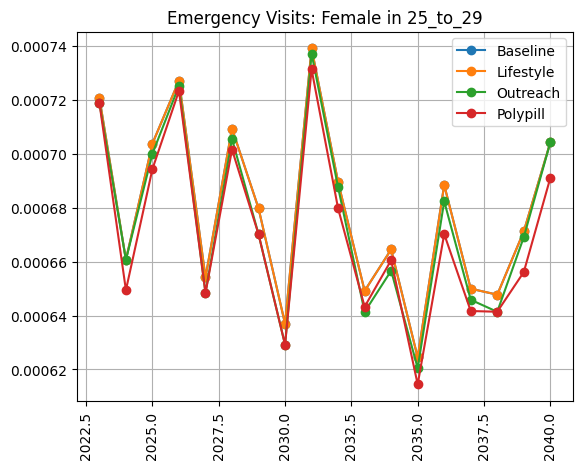

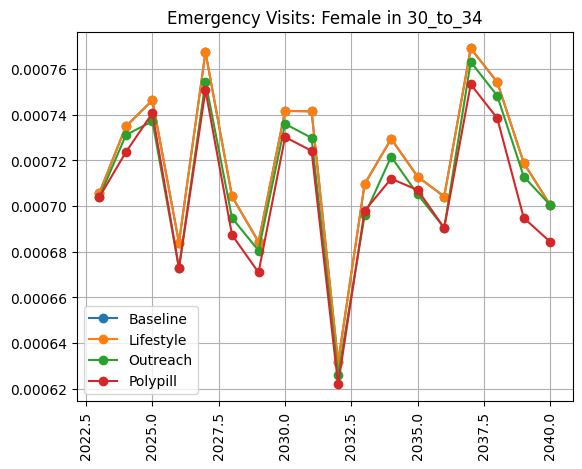

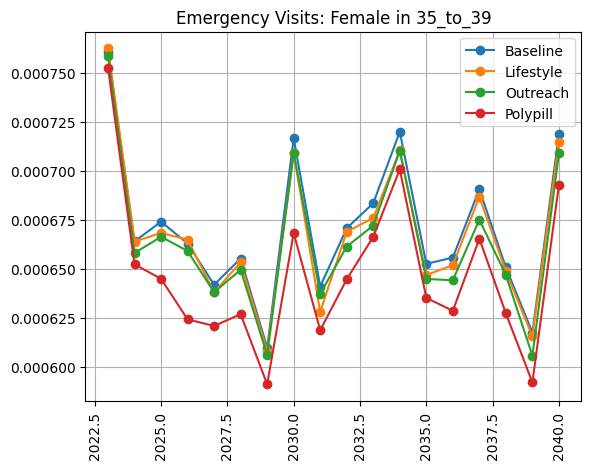

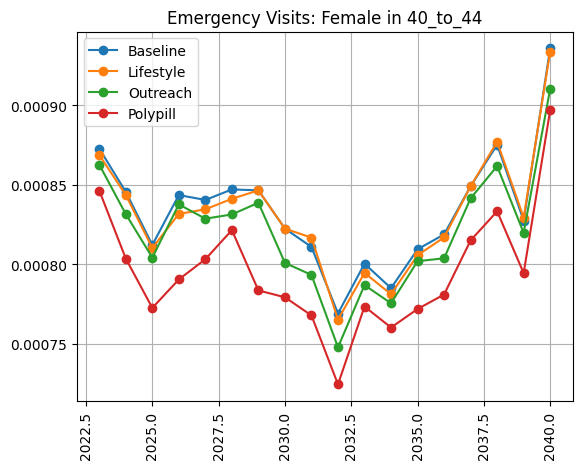

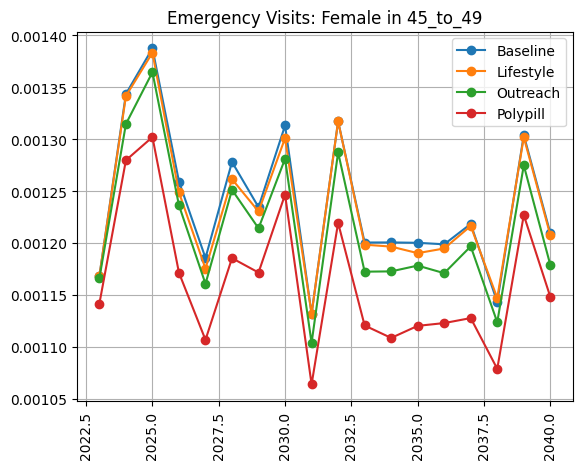

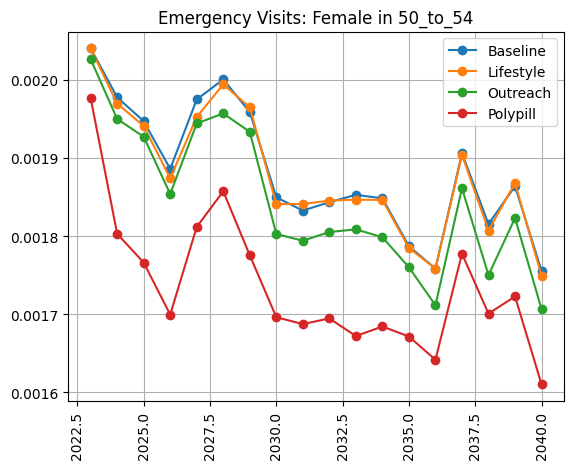

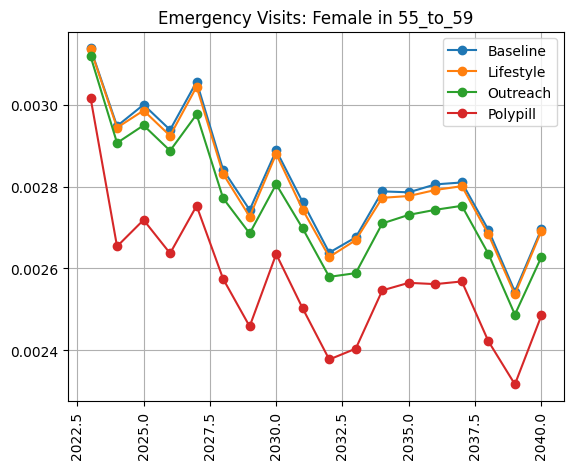

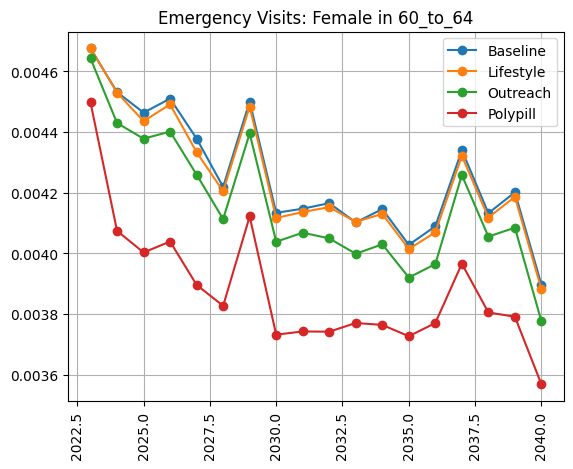

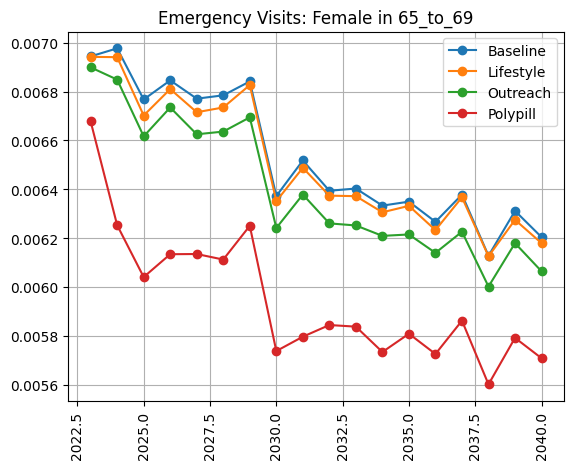

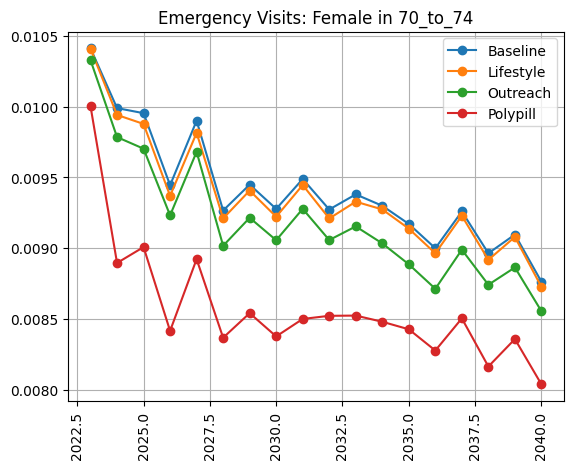

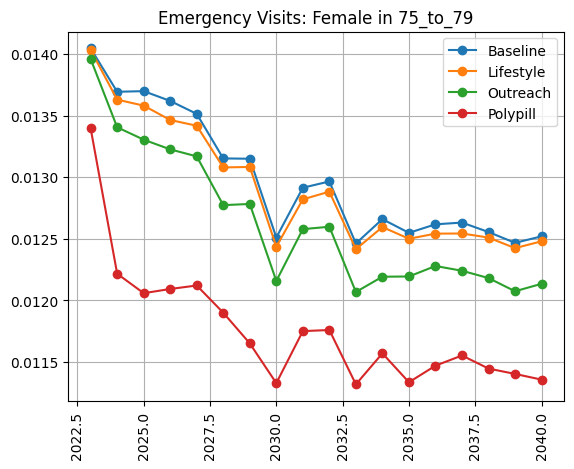

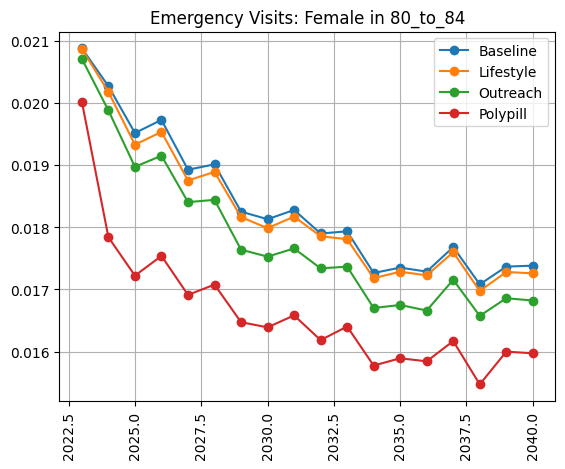

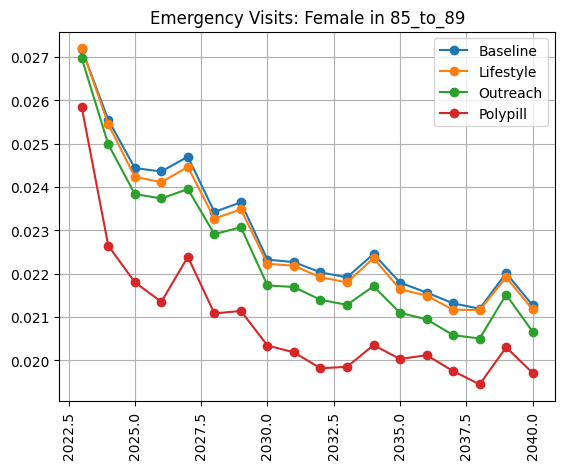

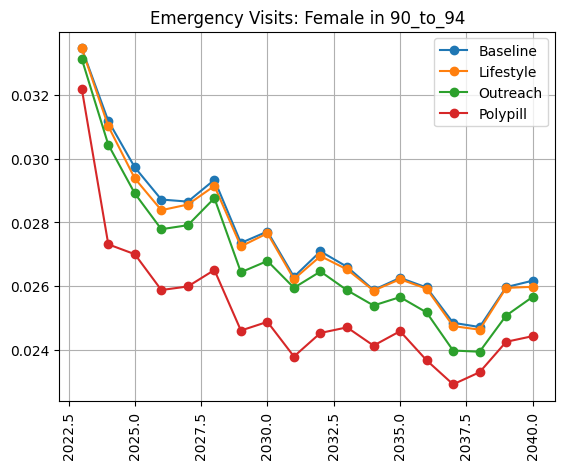

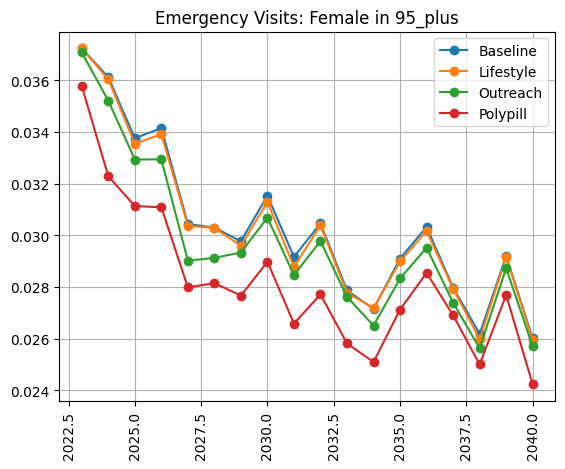

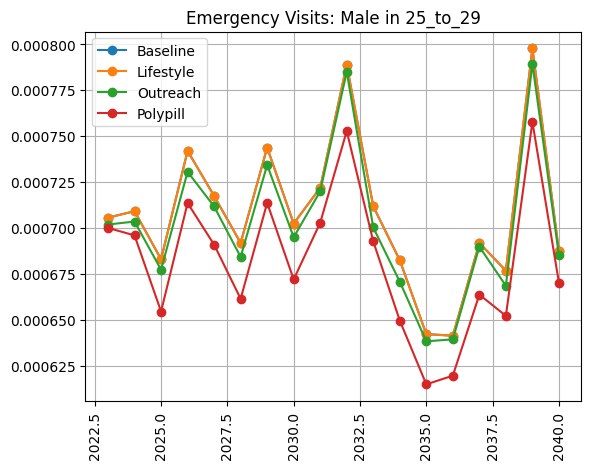

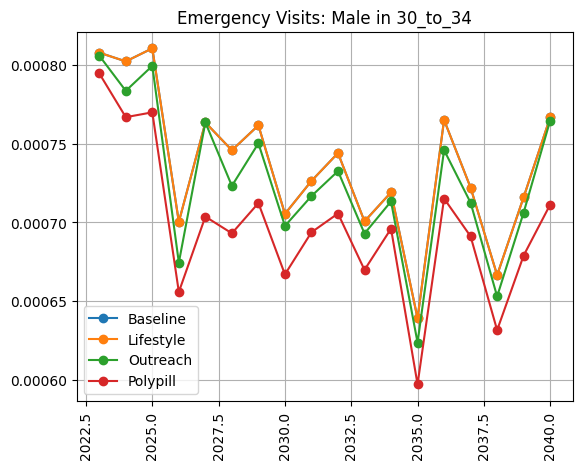

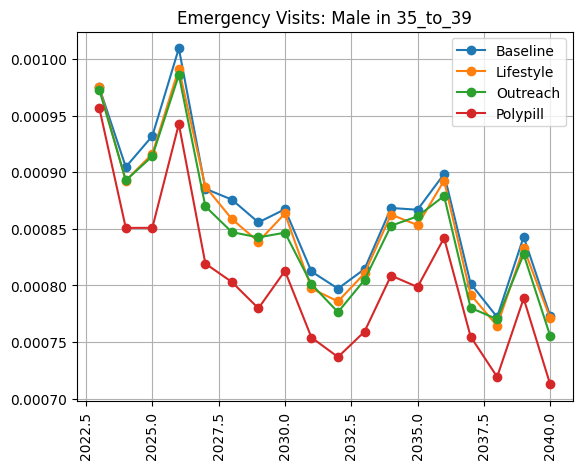

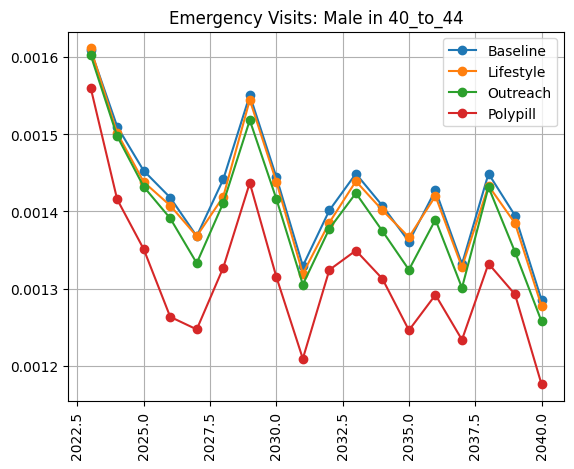

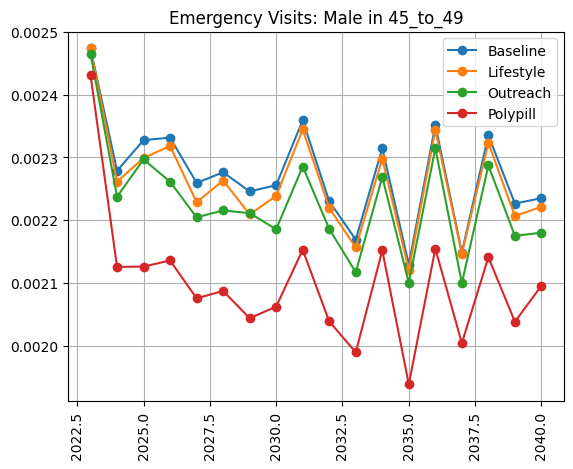

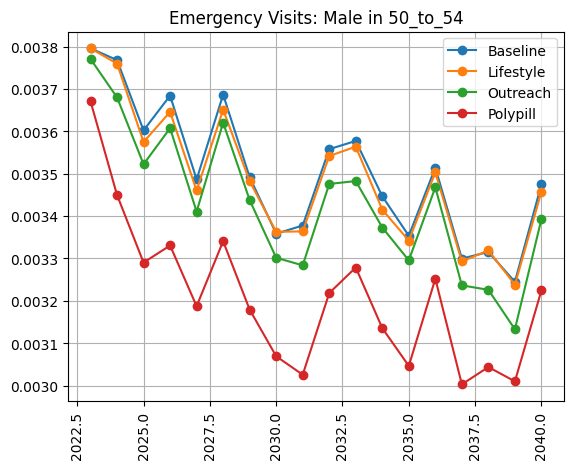

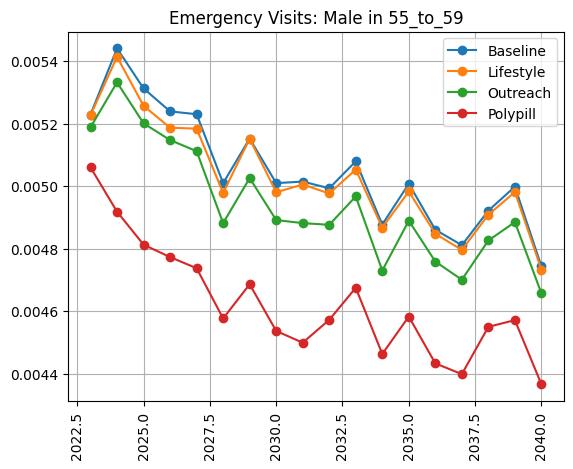

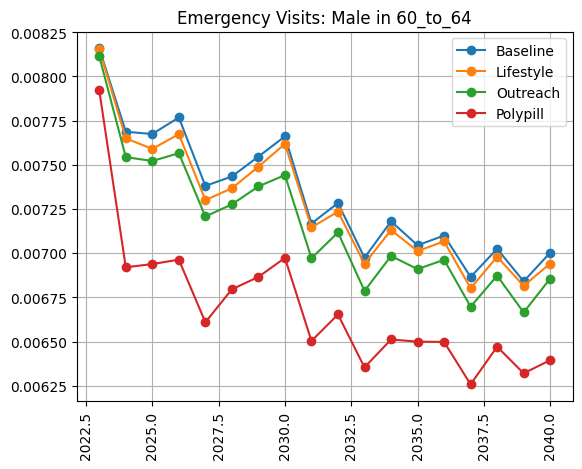

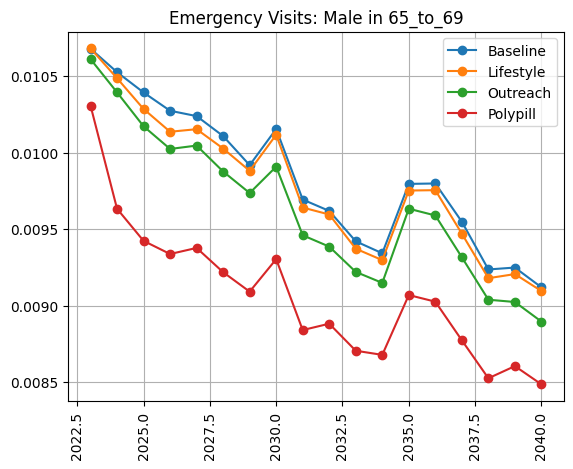

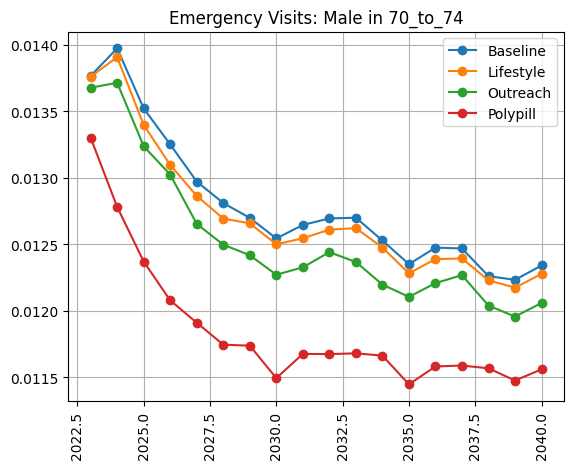

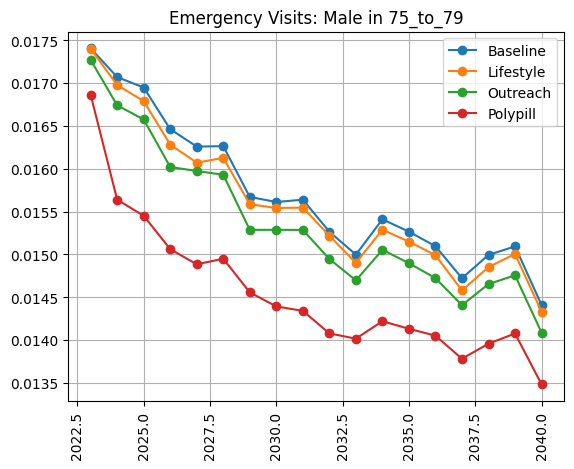

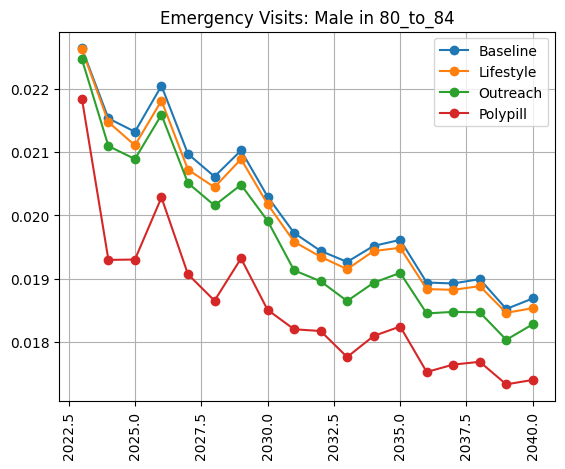

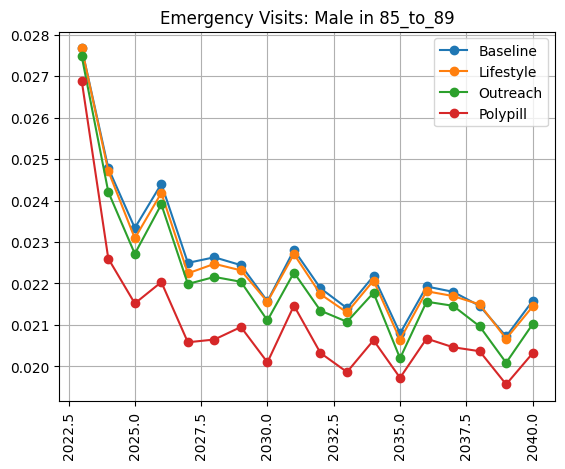

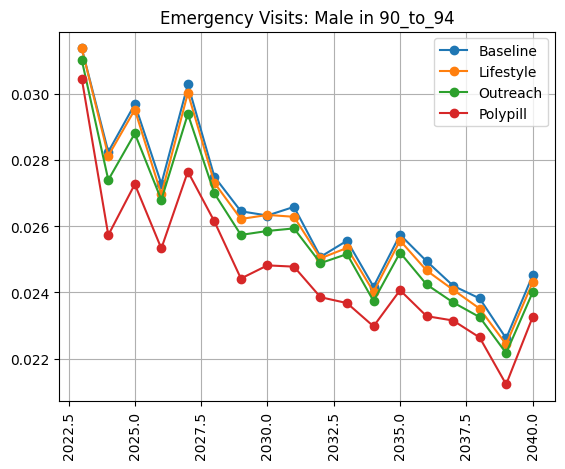

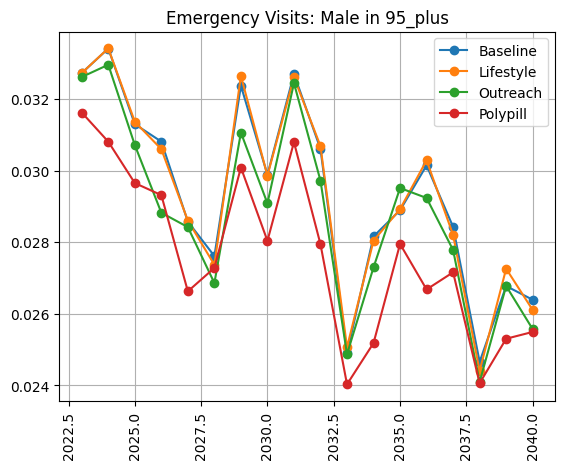

In [10]:
#%%capture
for sex in emergency_rate_summ.sex.unique():
    for age in emergency_rate_summ.age.unique():
        plt.figure() 
        subdata = emergency_rate_summ.loc[(emergency_rate_summ.sex==sex) & (emergency_rate_summ.age==age) & (emergency_rate_summ.scenario=='baseline')]
        plt.plot(subdata['year'], subdata['mean'], marker='o')
        subdata = emergency_rate_summ.loc[(emergency_rate_summ.sex==sex) & (emergency_rate_summ.age==age) & (emergency_rate_summ.scenario=='lifestyle_100')]
        plt.plot(subdata['year'], subdata['mean'], marker='o')
        subdata = emergency_rate_summ.loc[(emergency_rate_summ.sex==sex) & (emergency_rate_summ.age==age) & (emergency_rate_summ.scenario=='outreach_100')]
        plt.plot(subdata['year'], subdata['mean'], marker='o')
        subdata = emergency_rate_summ.loc[(emergency_rate_summ.sex==sex) & (emergency_rate_summ.age==age) & (emergency_rate_summ.scenario=='polypill_100')]
        plt.plot(subdata['year'], subdata['mean'], marker='o')
        plt.legend(['Baseline','Lifestyle','Outreach','Polypill'])
        plt.title(f'Emergency Visits: {sex} in {age}') 
        plt.xticks(rotation=90) 
        plt.grid()

In [11]:
all_visits = visits.loc[visits['visit_type']!='none'].reset_index()
all_visits = all_visits.groupby(['sex','age','year','input_draw','scenario']).value.sum().reset_index()
all_visits_rate = all_visits.merge(per_time_group[['ptvalue','sex','age','year','input_draw','scenario']], on=['sex','age','year','input_draw','scenario'])
all_visits_rate['all_visits_rate'] = all_visits_rate['value'] / all_visits_rate['ptvalue']
all_visits_rate_summ = (all_visits_rate
                .groupby(['age', 'sex', 'year','scenario'])
                .all_visits_rate.describe(percentiles=[.025, .975])
                .filter(['mean', '2.5%', '97.5%'])
                .reset_index())
all_visits_rate_summ.head()

age     sex  year       scenario      mean     2.5%     97.5%
0  25_to_29  Female  2023       baseline  2.465280  1.72539  3.814461
1  25_to_29  Female  2023  lifestyle_100  2.465280  1.72539  3.814461
2  25_to_29  Female  2023   lifestyle_50  2.465280  1.72539  3.814461
3  25_to_29  Female  2023   outreach_100  2.465279  1.72539  3.814461
4  25_to_29  Female  2023    outreach_50  2.465279  1.72539  3.814461

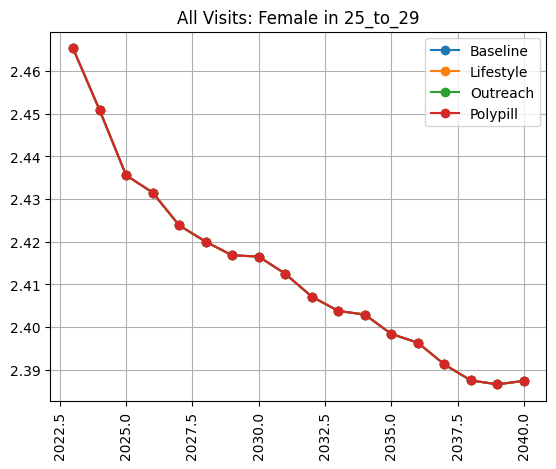

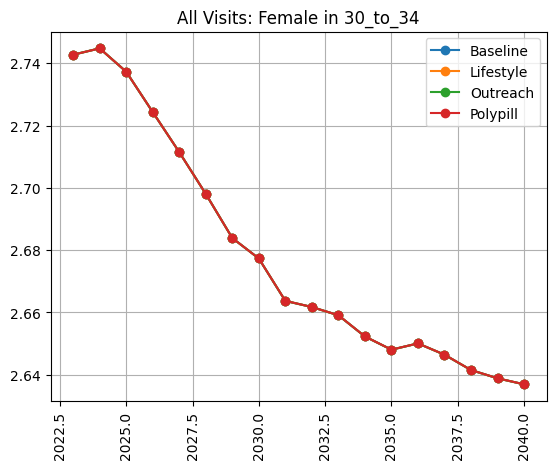

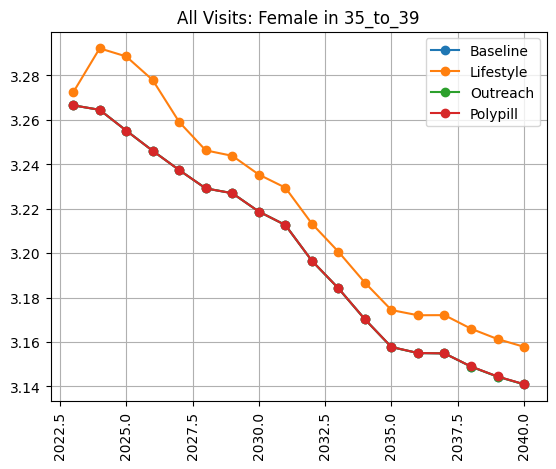

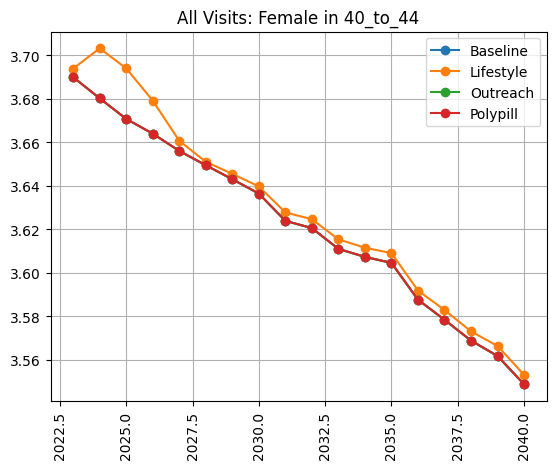

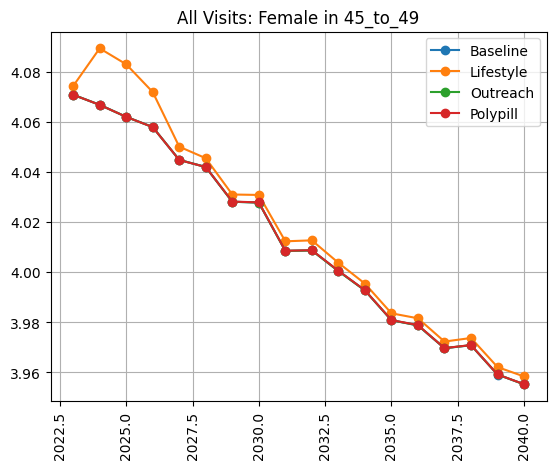

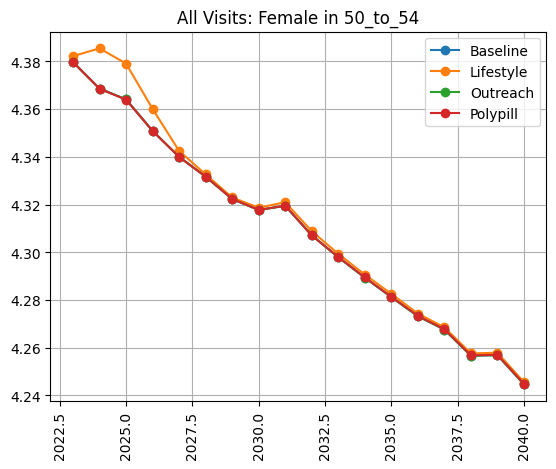

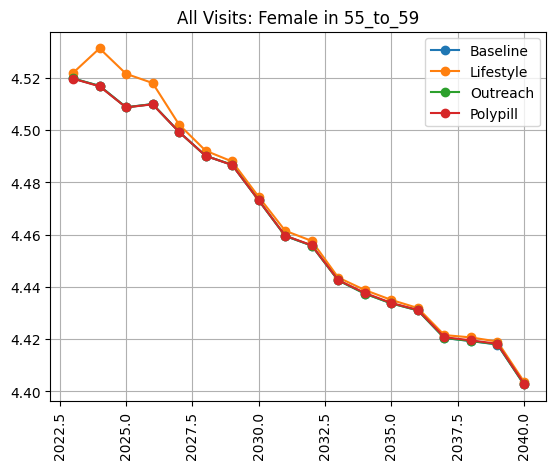

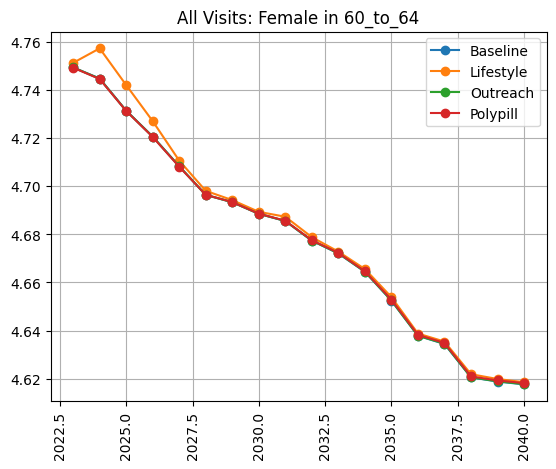

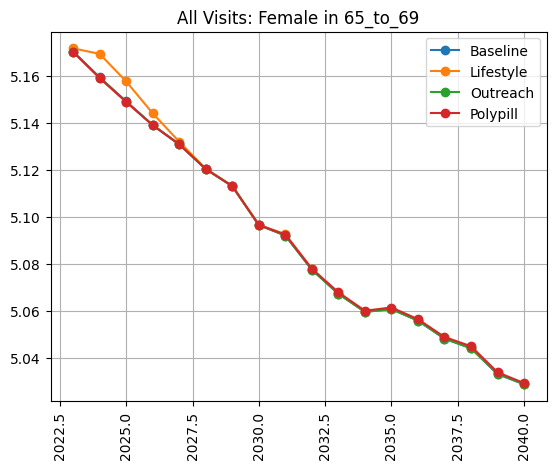

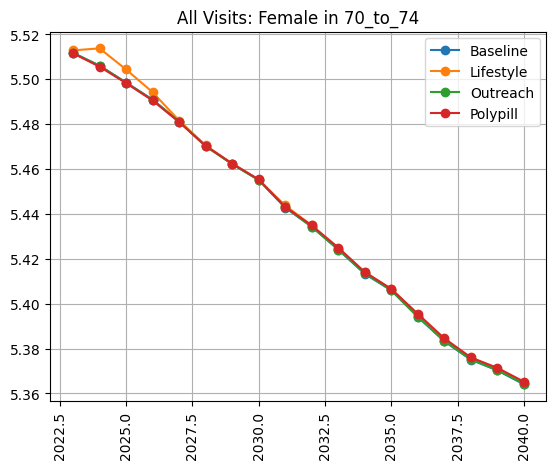

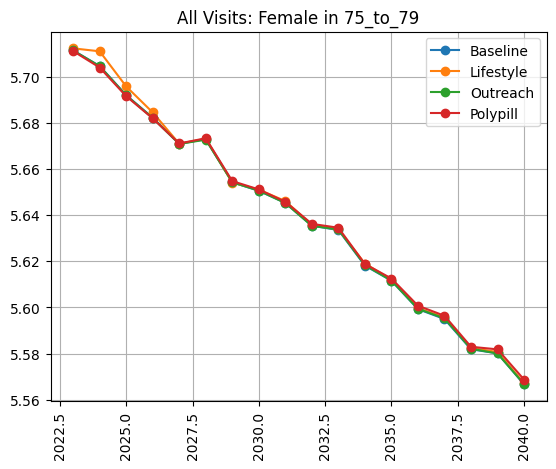

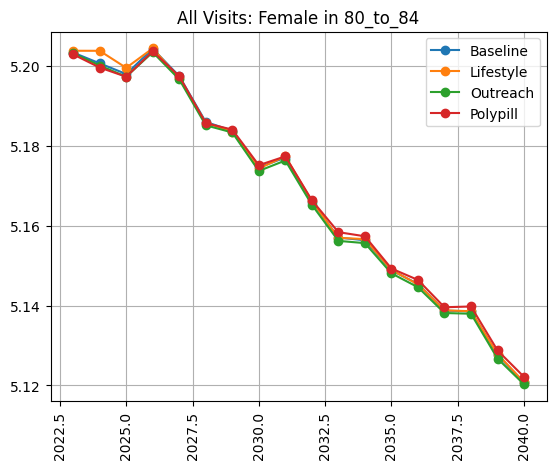

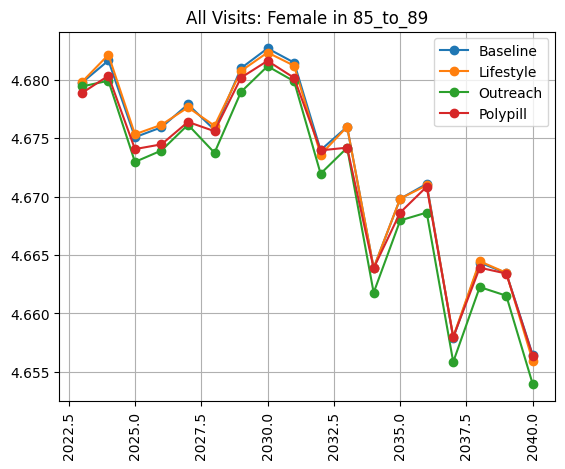

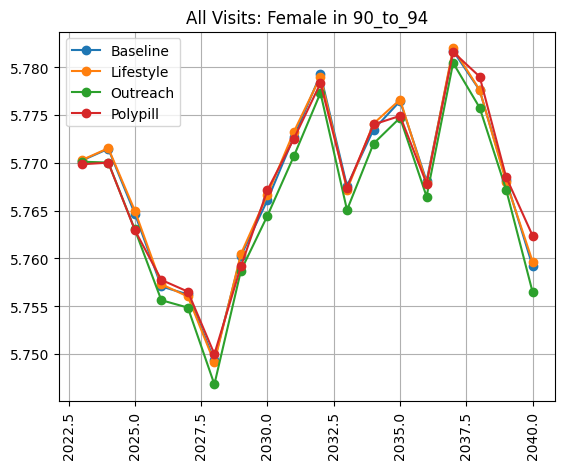

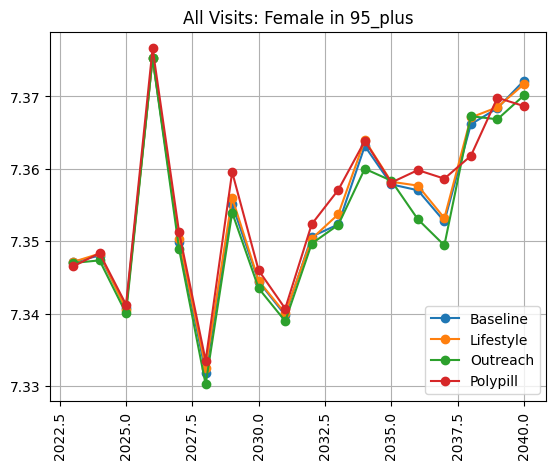

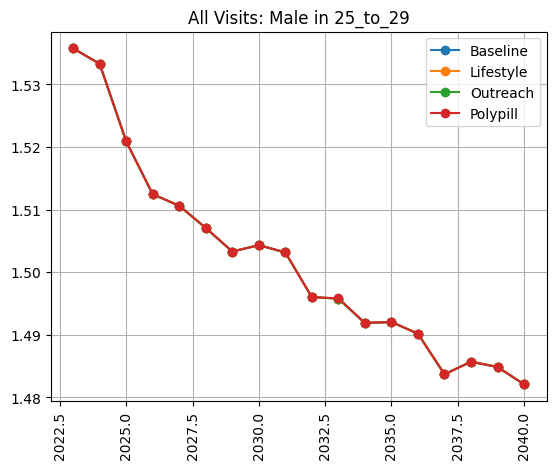

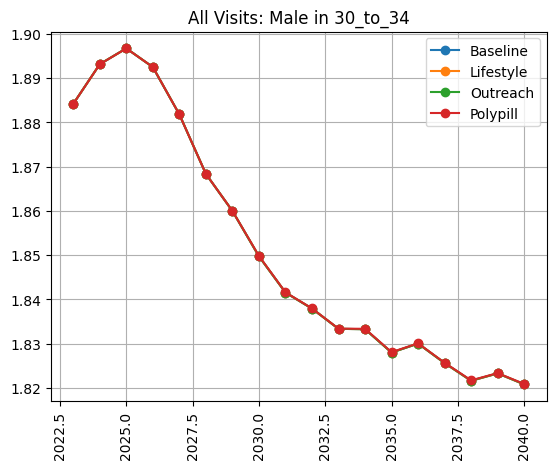

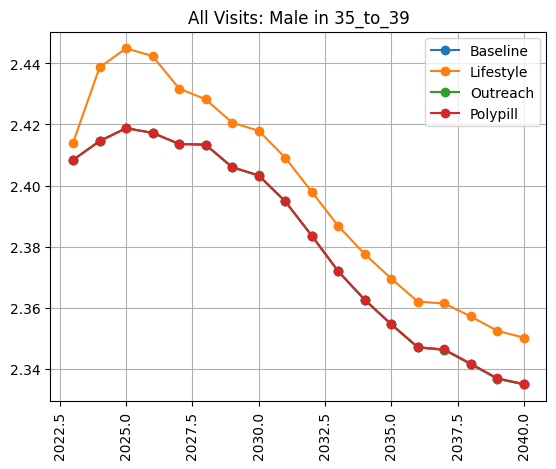

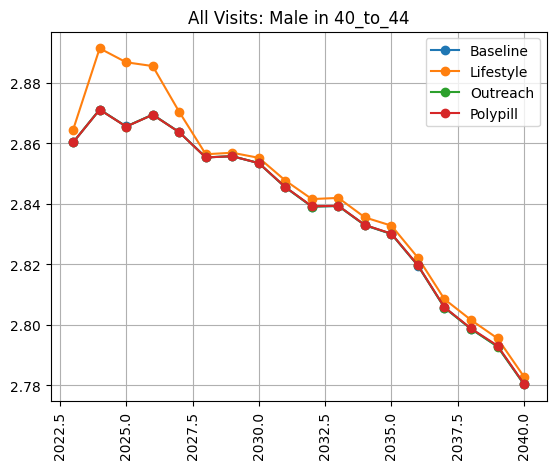

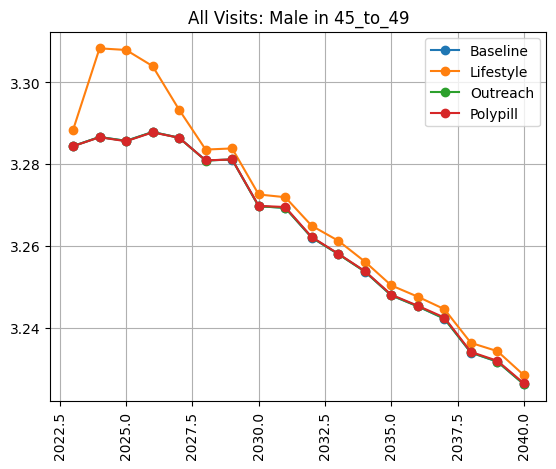

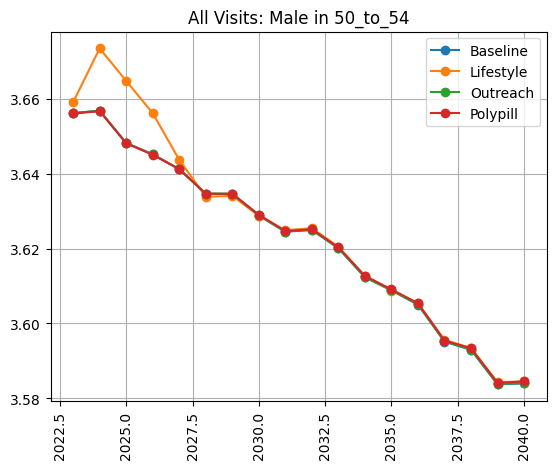

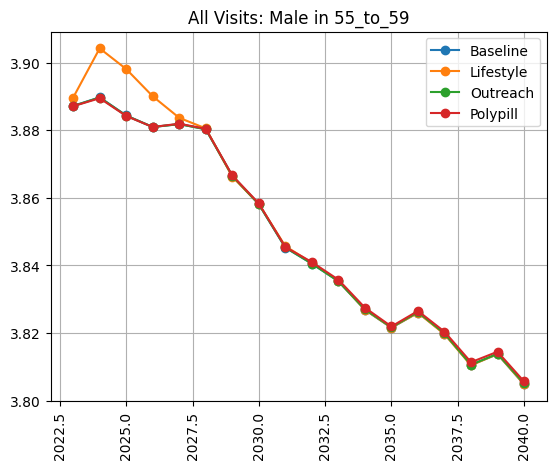

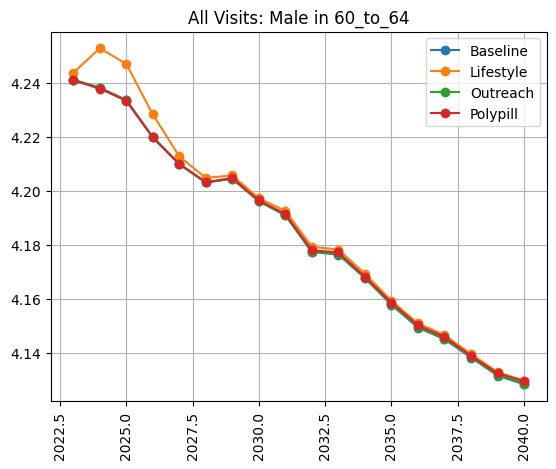

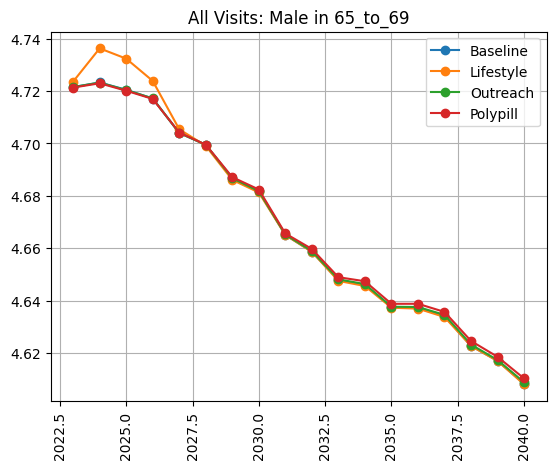

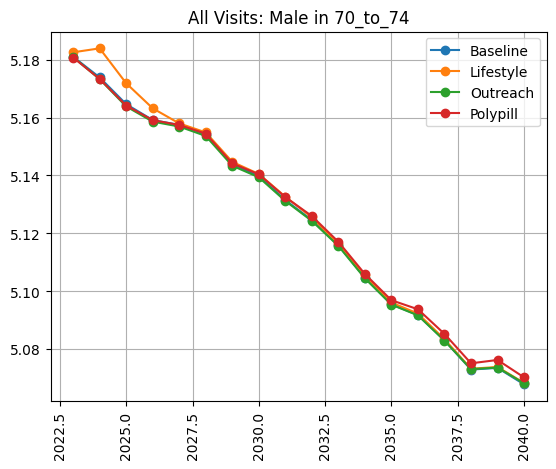

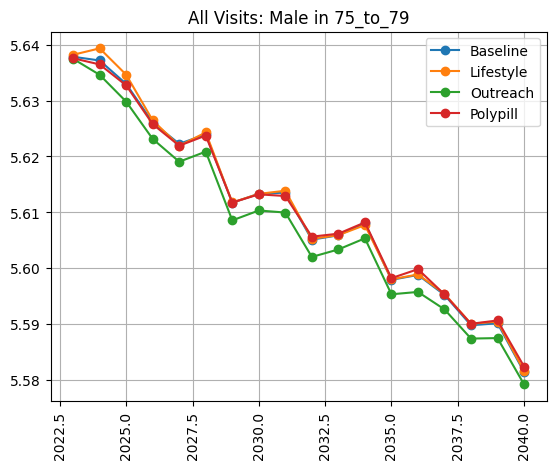

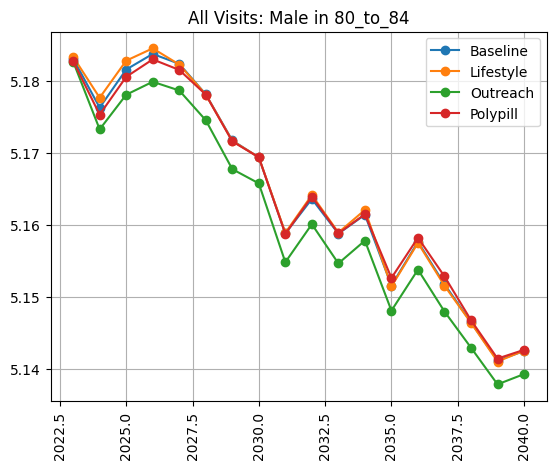

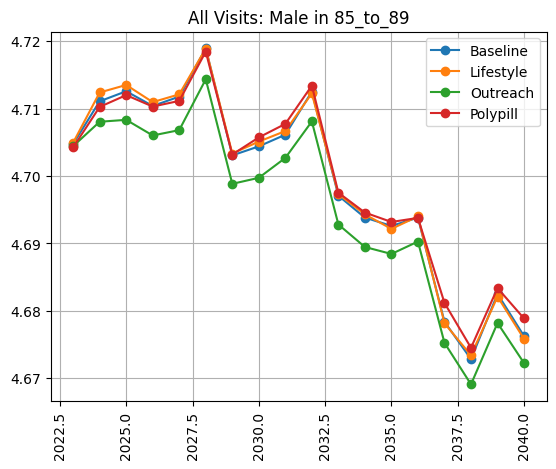

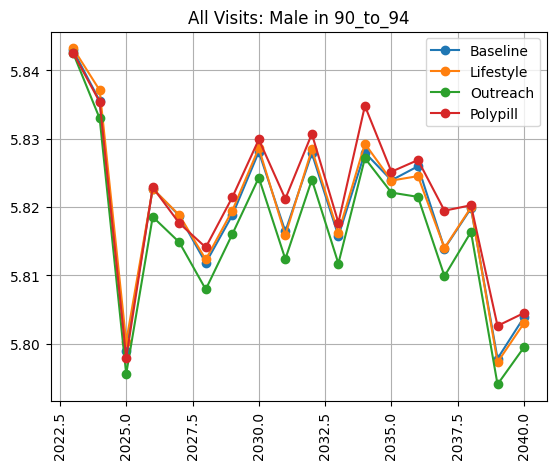

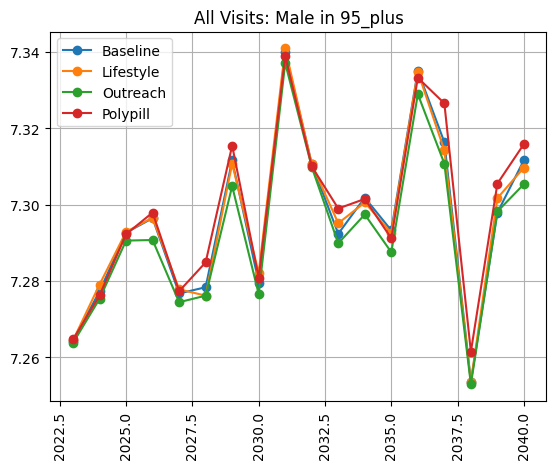

In [12]:
#%%capture
for sex in all_visits_rate_summ.sex.unique():
    for age in all_visits_rate_summ.age.unique():
        plt.figure() 
        subdata = all_visits_rate_summ.loc[(all_visits_rate_summ.sex==sex) & (all_visits_rate_summ.age==age) & (all_visits_rate_summ.scenario=='baseline')]
        plt.plot(subdata['year'], subdata['mean'], marker='o')
        subdata = all_visits_rate_summ.loc[(all_visits_rate_summ.sex==sex) & (all_visits_rate_summ.age==age) & (all_visits_rate_summ.scenario=='lifestyle_100')]
        plt.plot(subdata['year'], subdata['mean'], marker='o')
        subdata = all_visits_rate_summ.loc[(all_visits_rate_summ.sex==sex) & (all_visits_rate_summ.age==age) & (all_visits_rate_summ.scenario=='outreach_100')]
        plt.plot(subdata['year'], subdata['mean'], marker='o')
        subdata = all_visits_rate_summ.loc[(all_visits_rate_summ.sex==sex) & (all_visits_rate_summ.age==age) & (all_visits_rate_summ.scenario=='polypill_100')]
        plt.plot(subdata['year'], subdata['mean'], marker='o')
        plt.legend(['Baseline','Lifestyle','Outreach','Polypill'])
        plt.title(f'All Visits: {sex} in {age}') 
        plt.xticks(rotation=90) 
        plt.grid()